<a href="https://colab.research.google.com/github/chuqasmi/GNN/blob/main/MPhil_thesis_project_gnn_citations.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Node Classification with Graph Neural Networks

**Redesign:** [MUHAMMAD USMAN](https://www.linkedin.com/in/muhammad-usman-538297229//)<br>
**Date created:** 2024/03/30<br>
**Last modified:** 2024/04/20<br>
**About:** A project on Implementing a graph neural network model for predicting the topic of a paper given its citations.

## Introduction

Many datasets in various machine learning (ML) applications have structural relationships
between their entities, which can be represented as graphs. Such application includes
social and communication networks analysis, traffic prediction, and fraud detection.
[Graph representation Learning](https://www.cs.mcgill.ca/~wlh/grl_book/)
aims to build and train models for graph datasets to be used for a variety of ML tasks.

This example demonstrate a simple implementation of a [Graph Neural Network](https://arxiv.org/pdf/1901.00596.pdf)
(GNN) model. The model is used for a node prediction task on the [Cora dataset](https://relational.fit.cvut.cz/dataset/CORA)
to predict the subject of a paper given its words and citations network.

Note that, **we implement a Graph Convolution Layer from scratch** to provide better
understanding of how they work. However, there is a number of specialized TensorFlow-based
libraries that provide rich GNN APIs, such as [Spectral](https://graphneural.network/),
[StellarGraph](https://stellargraph.readthedocs.io/en/stable/README.html), and
[GraphNets](https://github.com/deepmind/graph_nets).

## Setup

In [ ]:
import os
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

## Prepare the Dataset

The Cora dataset consists of 2,708 scientific papers classified into one of seven classes.
The citation network consists of 5,429 links. Each paper has a binary word vector of size
1,433, indicating the presence of a corresponding word.

### Download the dataset

The dataset has two tap-separated files: `cora.cites` and `cora.content`.

1. The `cora.cites` includes the citation records with two columns:
`cited_paper_id` (target) and `citing_paper_id` (source).
2. The `cora.content` includes the paper content records with 1,435 columns:
`paper_id`, `subject`, and 1,433 binary features.

Let's download the dataset.

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)
data_dir = os.path.join(os.path.dirname(zip_file), "cora")

### Process and visualize the dataset

Then we load the citations data into a Pandas DataFrame.

In [ ]:
citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)
print("Citations shape:", citations.shape)

Now we display a sample of the `citations` DataFrame.
The `target` column includes the paper ids cited by the paper ids in the `source` column.

In [ ]:
citations.sample(frac=1).head()

Now let's load the papers data into a Pandas DataFrame.

In [ ]:
column_names = ["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"]
papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"), sep="\t", header=None, names=column_names,
)
print("Papers shape:", papers.shape)

Now we display a sample of the `papers` DataFrame. The DataFrame includes the `paper_id`
and the `subject` columns, as well as 1,433 binary column representing whether a term exists
in the paper or not.

In [ ]:
print(papers.sample(5).T)

Let's display the count of the papers in each subject.

In [ ]:
print(papers.subject.value_counts())

We convert the paper ids and the subjects into zero-based indices.

In [ ]:
class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

Now let's visualize the citation graph. Each node in the graph represents a paper,
and the color of the node corresponds to its subject. Note that we only show a sample of
the papers in the dataset.

In [ ]:
plt.figure(figsize=(10, 10))
colors = papers["subject"].tolist()
cora_graph = nx.from_pandas_edgelist(citations.sample(n=1500))
subjects = list(papers[papers["paper_id"].isin(list(cora_graph.nodes))]["subject"])
nx.draw_spring(cora_graph, node_size=15, node_color=subjects)


### Split the dataset into stratified train and test sets

In [ ]:
train_data, test_data = [], []

for _, group_data in papers.groupby("subject"):
    # Select around 50% of the dataset for training.
    random_selection = np.random.rand(len(group_data.index)) <= 0.5
    train_data.append(group_data[random_selection])
    test_data.append(group_data[~random_selection])

train_data = pd.concat(train_data).sample(frac=1)
test_data = pd.concat(test_data).sample(frac=1)

print("Train data shape:", train_data.shape)
print("Test data shape:", test_data.shape)

## Implement Train and Evaluate Experiment

In [ ]:
hidden_units = [32, 32]
learning_rate = 0.01
dropout_rate = 0.5
num_epochs = 300
batch_size = 256

This function compiles and trains an input model using the given training data.

In [ ]:

def run_experiment(model, x_train, y_train):
    # Compile the model.
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
    )
    # Create an early stopping callback.
    early_stopping = keras.callbacks.EarlyStopping(
        monitor="val_acc", patience=50, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        epochs=num_epochs,
        batch_size=batch_size,
        validation_split=0.15,
        callbacks=[early_stopping],
    )

    return history


This function displays the loss and accuracy curves of the model during training.

In [ ]:

def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "test"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["acc"])
    ax2.plot(history.history["val_acc"])
    ax2.legend(["train", "test"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()


## Implement Feedforward Network (FFN) Module

We will use this module in the baseline and the GNN models.

In [ ]:

def create_ffn(hidden_units, dropout_rate, name=None):
    fnn_layers = []

    for units in hidden_units:
        fnn_layers.append(layers.BatchNormalization())
        fnn_layers.append(layers.Dropout(dropout_rate))
        fnn_layers.append(layers.Dense(units, activation=tf.nn.gelu))

    return keras.Sequential(fnn_layers, name=name)


## Build a Baseline Neural Network Model

### Prepare the data for the baseline model

In [ ]:
feature_names = list(set(papers.columns) - {"paper_id", "subject"})
num_features = len(feature_names)
num_classes = len(class_idx)

# Create train and test features as a numpy array.
x_train = train_data[feature_names].to_numpy()
x_test = test_data[feature_names].to_numpy()
# Create train and test targets as a numpy array.
y_train = train_data["subject"]
y_test = test_data["subject"]

### Implement a baseline classifier

We add five FFN blocks with skip connections, so that we generate a baseline model with
roughly the same number of parameters as the GNN models to be built later.

In [ ]:

def create_baseline_model(hidden_units, num_classes, dropout_rate=0.2):
    inputs = layers.Input(shape=(num_features,), name="input_features")
    x = create_ffn(hidden_units, dropout_rate, name=f"ffn_block1")(inputs)
    for block_idx in range(4):
        # Create an FFN block.
        x1 = create_ffn(hidden_units, dropout_rate, name=f"ffn_block{block_idx + 2}")(x)
        # Add skip connection.
        x = layers.Add(name=f"skip_connection{block_idx + 2}")([x, x1])
    # Compute logits.
    logits = layers.Dense(num_classes, name="logits")(x)
    # Create the model.
    return keras.Model(inputs=inputs, outputs=logits, name="baseline")


baseline_model = create_baseline_model(hidden_units, num_classes, dropout_rate)
baseline_model.summary()

### Train the baseline classifier

In [ ]:
history = run_experiment(baseline_model, x_train, y_train)

Let's plot the learning curves.

In [ ]:
display_learning_curves(history)

Now we evaluate the baseline model on the test data split.

In [ ]:
_, test_accuracy = baseline_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

### Examine the baseline model predictions

Let's create new data instances by randomly generating binary word vectors with respect to
the word presence probabilities.

In [ ]:

def generate_random_instances(num_instances):
    token_probability = x_train.mean(axis=0)
    instances = []
    for _ in range(num_instances):
        probabilities = np.random.uniform(size=len(token_probability))
        instance = (probabilities <= token_probability).astype(int)
        instances.append(instance)

    return np.array(instances)


def display_class_probabilities(probabilities):
    for instance_idx, probs in enumerate(probabilities):
        print(f"Instance {instance_idx + 1}:")
        for class_idx, prob in enumerate(probs):
            print(f"- {class_values[class_idx]}: {round(prob * 100, 2)}%")


Now we show the baseline model predictions given these randomly generated instances.

In [ ]:
new_instances = generate_random_instances(num_classes)
logits = baseline_model.predict(new_instances)
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

## Build a Graph Neural Network Model

### Prepare the data for the graph model

Preparing and loading the graphs data into the model for training is the most challenging
part in GNN models, which is addressed in different ways by the specialised libraries.
In this example, we show a simple approach for preparing and using graph data that is suitable
if your dataset consists of a single graph that fits entirely in memory.

The graph data is represented by the `graph_info` tuple, which consists of the following
three elements:

1. `node_features`: This is a `[num_nodes, num_features]` NumPy array that includes the
node features. In this dataset, the nodes are the papers, and the `node_features` are the
word-presence binary vectors of each paper.
2. `edges`:  This is `[num_edges, num_edges]` NumPy array representing a sparse
[adjacency matrix](https://en.wikipedia.org/wiki/Adjacency_matrix#:~:text=In%20graph%20theory%20and%20computer,with%20zeros%20on%20its%20diagonal.)
of the links between the nodes. In this example, the links are the citations between the papers.
3. `edge_weights` (optional): This is a `[num_edges]` NumPy array that includes the edge weights, which *quantify*
the relationships between nodes in the graph. In this example, there are no weights for the paper citations.

In [ ]:
# Create an edges array (sparse adjacency matrix) of shape [2, num_edges].
edges = citations[["source", "target"]].to_numpy().T
# Create an edge weights array of ones.
edge_weights = tf.ones(shape=edges.shape[1])
# Create a node features array of shape [num_nodes, num_features].
node_features = tf.cast(
    papers.sort_values("paper_id")[feature_names].to_numpy(), dtype=tf.dtypes.float32
)
# Create graph info tuple with node_features, edges, and edge_weights.
graph_info = (node_features, edges, edge_weights)

print("Edges shape:", edges.shape)
print("Nodes shape:", node_features.shape)

### Implement a graph convolution layer

We implement a graph convolution module as a [Keras Layer](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Layer?version=nightly).
Our `GraphConvLayer` performs the following steps:

1. **Prepare**: The input node representations are processed using a FFN to produce a *message*. You can simplify
the processing by only applying linear transformation to the representations.
2. **Aggregate**: The messages of the neighbours of each node are aggregated with
respect to the `edge_weights` using a *permutation invariant* pooling operation, such as *sum*, *mean*, and *max*,
to prepare a single aggregated message for each node. See, for example, [tf.math.unsorted_segment_sum](https://www.tensorflow.org/api_docs/python/tf/math/unsorted_segment_sum)
APIs used to aggregate neighbour messages.
3. **Update**: The `node_repesentations` and `aggregated_messages`—both of shape `[num_nodes, representation_dim]`—
are combined and processed to produce the new state of the node representations (node embeddings).
If `combination_type` is `gru`, the `node_repesentations` and `aggregated_messages` are stacked to create a sequence,
then processed by a GRU layer. Otherwise, the `node_repesentations` and `aggregated_messages` are added
or concatenated, then processed using a FFN.


The technique implemented use ideas from [Graph Convolutional Networks](https://arxiv.org/abs/1609.02907),
[GraphSage](https://arxiv.org/abs/1706.02216), [Graph Isomorphism Network](https://arxiv.org/abs/1810.00826),
[Simple Graph Networks](https://arxiv.org/abs/1902.07153), and
[Gated Graph Sequence Neural Networks](https://arxiv.org/abs/1511.05493).
Two other key techniques that are not covered are [Graph Attention Networks](https://arxiv.org/abs/1710.10903)
and [Message Passing Neural Networks](https://arxiv.org/abs/1704.01212).

In [ ]:

def create_gru(hidden_units, dropout_rate):
    inputs = keras.layers.Input(shape=(2, hidden_units[0]))
    x = inputs
    for units in hidden_units:
      x = layers.GRU(
          units=units,
          activation="tanh",
          recurrent_activation="sigmoid",
          return_sequences=True,
          dropout=dropout_rate,
          return_state=False,
          recurrent_dropout=dropout_rate,
      )(x)
    return keras.Model(inputs=inputs, outputs=x)


class GraphConvLayer(layers.Layer):
    def __init__(
        self,
        hidden_units,
        dropout_rate=0.2,
        aggregation_type="mean",
        combination_type="concat",
        normalize=False,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        self.aggregation_type = aggregation_type
        self.combination_type = combination_type
        self.normalize = normalize

        self.ffn_prepare = create_ffn(hidden_units, dropout_rate)
        if self.combination_type == "gru":
            self.update_fn = create_gru(hidden_units, dropout_rate)
        else:
            self.update_fn = create_ffn(hidden_units, dropout_rate)

    def prepare(self, node_repesentations, weights=None):
        # node_repesentations shape is [num_edges, embedding_dim].
        messages = self.ffn_prepare(node_repesentations)
        if weights is not None:
            messages = messages * tf.expand_dims(weights, -1)
        return messages

    def aggregate(self, node_indices, neighbour_messages, node_repesentations):
        # node_indices shape is [num_edges].
        # neighbour_messages shape: [num_edges, representation_dim].
        # node_repesentations shape is [num_nodes, representation_dim].
        num_nodes = node_repesentations.shape[0]
        if self.aggregation_type == "sum":
            aggregated_message = tf.math.unsorted_segment_sum(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "mean":
            aggregated_message = tf.math.unsorted_segment_mean(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        elif self.aggregation_type == "max":
            aggregated_message = tf.math.unsorted_segment_max(
                neighbour_messages, node_indices, num_segments=num_nodes
            )
        else:
            raise ValueError(f"Invalid aggregation type: {self.aggregation_type}.")

        return aggregated_message

    def update(self, node_repesentations, aggregated_messages):
        # node_repesentations shape is [num_nodes, representation_dim].
        # aggregated_messages shape is [num_nodes, representation_dim].
        if self.combination_type == "gru":
            # Create a sequence of two elements for the GRU layer.
            h = tf.stack([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "concat":
            # Concatenate the node_repesentations and aggregated_messages.
            h = tf.concat([node_repesentations, aggregated_messages], axis=1)
        elif self.combination_type == "add":
            # Add node_repesentations and aggregated_messages.
            h = node_repesentations + aggregated_messages
        else:
            raise ValueError(f"Invalid combination type: {self.combination_type}.")

        # Apply the processing function.
        node_embeddings = self.update_fn(h)
        if self.combination_type == "gru":
            node_embeddings = tf.unstack(node_embeddings, axis=1)[-1]

        if self.normalize:
            node_embeddings = tf.nn.l2_normalize(node_embeddings, axis=-1)
        return node_embeddings

    def call(self, inputs):
        """Process the inputs to produce the node_embeddings.

        inputs: a tuple of three elements: node_repesentations, edges, edge_weights.
        Returns: node_embeddings of shape [num_nodes, representation_dim].
        """

        node_repesentations, edges, edge_weights = inputs
        # Get node_indices (source) and neighbour_indices (target) from edges.
        node_indices, neighbour_indices = edges[0], edges[1]
        # neighbour_repesentations shape is [num_edges, representation_dim].
        neighbour_repesentations = tf.gather(node_repesentations, neighbour_indices)

        # Prepare the messages of the neighbours.
        neighbour_messages = self.prepare(neighbour_repesentations, edge_weights)
        # Aggregate the neighbour messages.
        aggregated_messages = self.aggregate(
            node_indices, neighbour_messages, node_repesentations
        )
        # Update the node embedding with the neighbour messages.
        return self.update(node_repesentations, aggregated_messages)


### Implement a graph neural network node classifier

The GNN classification model follows the [Design Space for Graph Neural Networks](https://arxiv.org/abs/2011.08843) approach,
as follows:

1. Apply preprocessing using FFN to the node features to generate initial node representations.
2. Apply one or more graph convolutional layer, with skip connections,  to the node representation
to produce node embeddings.
3. Apply post-processing using FFN to the node embeddings to generate the final node embeddings.
4. Feed the node embeddings in a Softmax layer to predict the node class.

Each graph convolutional layer added captures information from a further level of neighbours.
However, adding many graph convolutional layer can cause oversmoothing, where the model
produces similar embeddings for all the nodes.

Note that the `graph_info` passed to the constructor of the Keras model, and used as a *property*
of the Keras model object, rather than input data for training or prediction.
The model will accept a **batch** of `node_indices`, which are used to lookup the
node features and neighbours from the `graph_info`.

In [ ]:

class GNNNodeClassifier(tf.keras.Model):
    def __init__(
        self,
        graph_info,
        num_classes,
        hidden_units,
        aggregation_type="sum",
        combination_type="concat",
        dropout_rate=0.2,
        normalize=True,
        *args,
        **kwargs,
    ):
        super().__init__(*args, **kwargs)

        # Unpack graph_info to three elements: node_features, edges, and edge_weight.
        node_features, edges, edge_weights = graph_info
        self.node_features = node_features
        self.edges = edges
        self.edge_weights = edge_weights
        # Set edge_weights to ones if not provided.
        if self.edge_weights is None:
            self.edge_weights = tf.ones(shape=edges.shape[1])
        # Scale edge_weights to sum to 1.
        self.edge_weights = self.edge_weights / tf.math.reduce_sum(self.edge_weights)

        # Create a process layer.
        self.preprocess = create_ffn(hidden_units, dropout_rate, name="preprocess")
        # Create the first GraphConv layer.
        self.conv1 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv1",
        )
        # Create the second GraphConv layer.
        self.conv2 = GraphConvLayer(
            hidden_units,
            dropout_rate,
            aggregation_type,
            combination_type,
            normalize,
            name="graph_conv2",
        )
        # Create a postprocess layer.
        self.postprocess = create_ffn(hidden_units, dropout_rate, name="postprocess")
        # Create a compute logits layer.
        self.compute_logits = layers.Dense(units=num_classes, name="logits")

    def call(self, input_node_indices):
        # Preprocess the node_features to produce node representations.
        x = self.preprocess(self.node_features)
        # Apply the first graph conv layer.
        x1 = self.conv1((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x1 + x
        # Apply the second graph conv layer.
        x2 = self.conv2((x, self.edges, self.edge_weights))
        # Skip connection.
        x = x2 + x
        # Postprocess node embedding.
        x = self.postprocess(x)
        # Fetch node embeddings for the input node_indices.
        node_embeddings = tf.gather(x, input_node_indices)
        # Compute logits
        return self.compute_logits(node_embeddings)


Let's test instantiating and calling the GNN model.
Notice that if you provide `N` node indices, the output will be a tensor of shape `[N, num_classes]`,
regardless of the size of the graph.

In [ ]:
gnn_model = GNNNodeClassifier(
    graph_info=graph_info,
    num_classes=num_classes,
    hidden_units=hidden_units,
    dropout_rate=dropout_rate,
    name="gnn_model",
)

print("GNN output shape:", gnn_model([1, 10, 100]))

gnn_model.summary()

### Train the GNN model

Note that we use the standard *supervised* cross-entropy loss to train the model.
However, we can add another *self-supervised* loss term for the generated node embeddings
that makes sure that neighbouring nodes in graph have similar representations, while faraway
nodes have dissimilar representations.

In [ ]:
x_train = train_data.paper_id.to_numpy()
history = run_experiment(gnn_model, x_train, y_train)

Let's plot the learning curves

In [ ]:
display_learning_curves(history)

Now we evaluate the GNN model on the test data split.
The results may vary depending on the training sample, however the GNN model always outperforms
the baseline model in terms of the test accuracy.

In [ ]:
x_test = test_data.paper_id.to_numpy()
_, test_accuracy = gnn_model.evaluate(x=x_test, y=y_test, verbose=0)
print(f"Test accuracy: {round(test_accuracy * 100, 2)}%")

### Examine the GNN model predictions

Let's add the new instances as nodes to the `node_features`, and generate links
(citations) to existing nodes.

In [ ]:
# First we add the N new_instances as nodes to the graph
# by appending the new_instance to node_features.
num_nodes = node_features.shape[0]
new_node_features = np.concatenate([node_features, new_instances])
# Second we add the M edges (citations) from each new node to a set
# of existing nodes in a particular subject
new_node_indices = [i + num_nodes for i in range(num_classes)]
new_citations = []
for subject_idx, group in papers.groupby("subject"):
    subject_papers = list(group.paper_id)
    # Select random x papers specific subject.
    selected_paper_indices1 = np.random.choice(subject_papers, 5)
    # Select random y papers from any subject (where y < x).
    selected_paper_indices2 = np.random.choice(list(papers.paper_id), 2)
    # Merge the selected paper indices.
    selected_paper_indices = np.concatenate(
        [selected_paper_indices1, selected_paper_indices2], axis=0
    )
    # Create edges between a citing paper idx and the selected cited papers.
    citing_paper_indx = new_node_indices[subject_idx]
    for cited_paper_idx in selected_paper_indices:
        new_citations.append([citing_paper_indx, cited_paper_idx])

new_citations = np.array(new_citations).T
new_edges = np.concatenate([edges, new_citations], axis=1)

Now let's update the `node_features` and the `edges` in the GNN model.

In [ ]:
print("Original node_features shape:", gnn_model.node_features.shape)
print("Original edges shape:", gnn_model.edges.shape)
gnn_model.node_features = new_node_features
gnn_model.edges = new_edges
gnn_model.edge_weights = tf.ones(shape=new_edges.shape[1])
print("New node_features shape:", gnn_model.node_features.shape)
print("New edges shape:", gnn_model.edges.shape)

logits = gnn_model.predict(tf.convert_to_tensor(new_node_indices))
probabilities = keras.activations.softmax(tf.convert_to_tensor(logits)).numpy()
display_class_probabilities(probabilities)

Notice that the probabilities of the expected subjects
(to which several citations are added) are higher compared to the baseline model.

## Introduction

[Graph neural networks](https://en.wikipedia.org/wiki/Graph_neural_network)
is the preferred neural network architecture for processing data structured as
graphs (for example, social networks or molecule structures), yielding
better results than fully-connected networks or convolutional networks.

In this tutorial, we will implement a specific graph neural network known as a
[Graph Attention Network](https://arxiv.org/abs/1710.10903) (GAT) to predict labels of
scientific papers based on what type of papers cite them (using the
[Cora](https://linqs.soe.ucsc.edu/data) dataset).

### References

For more information on GAT, see the original paper
[Graph Attention Networks](https://arxiv.org/abs/1710.10903) as well as
[DGL's Graph Attention Networks](https://docs.dgl.ai/en/0.4.x/tutorials/models/1_gnn/9_gat.html)
documentation.

Graph attention network (GAT) for node classification

### Import packages

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 6)
pd.set_option("display.max_rows", 6)
np.random.seed(2)

## Obtain the dataset

The preparation of the [Cora dataset](https://linqs.soe.ucsc.edu/data) follows that of the
[Node classification with Graph Neural Networks](https://keras.io/examples/graph/gnn_citations/)
tutorial. Refer to this tutorial for more details on the dataset and exploratory data analysis.
In brief, the Cora dataset consists of two files: `cora.cites` which contains *directed links* (citations) between
papers; and `cora.content` which contains *features* of the corresponding papers and one
of seven labels (the *subject* of the paper).

In [ ]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)

data_dir = os.path.join(os.path.dirname(zip_file), "cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
)

class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

print(citations)

print(papers)

In [ ]:
# Obtain random indices
random_indices = np.random.permutation(range(papers.shape[0]))

# 50/50 split
train_data = papers.iloc[random_indices[: len(random_indices) // 2]]
test_data = papers.iloc[random_indices[len(random_indices) // 2 :]]

prepare data

In [ ]:
# Obtain paper indices which will be used to gather node states
# from the graph later on when training the model
train_indices = train_data["paper_id"].to_numpy()
test_indices = test_data["paper_id"].to_numpy()

# Obtain ground truth labels corresponding to each paper_id
train_labels = train_data["subject"].to_numpy()
test_labels = test_data["subject"].to_numpy()

# Define graph, namely an edge tensor and a node feature tensor
edges = tf.convert_to_tensor(citations[["target", "source"]])
node_states = tf.convert_to_tensor(papers.sort_values("paper_id").iloc[:, 1:-1])

# Print shapes of the graph
print("Edges shape:\t\t", edges.shape)
print("Node features shape:", node_states.shape)

### (Multi-head) graph attention layer

The GAT model implements multi-head graph attention layers. The `MultiHeadGraphAttention`
layer is simply a concatenation (or averaging) of multiple graph attention layers
(`GraphAttention`), each with separate learnable weights `W`. The `GraphAttention` layer


In [ ]:

class GraphAttention(layers.Layer):
    def __init__(
        self,
        units,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.units = units
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):

        self.kernel = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel",
        )
        self.kernel_attention = self.add_weight(
            shape=(self.units * 2, 1),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel_attention",
        )
        self.built = True

    def call(self, inputs):
        node_states, edges = inputs

        # Linearly transform node states
        node_states_transformed = tf.matmul(node_states, self.kernel)

        # (1) Compute pair-wise attention scores
        node_states_expanded = tf.gather(node_states_transformed, edges)
        node_states_expanded = tf.reshape(
            node_states_expanded, (tf.shape(edges)[0], -1)
        )
        attention_scores = tf.nn.leaky_relu(
            tf.matmul(node_states_expanded, self.kernel_attention)
        )
        attention_scores = tf.squeeze(attention_scores, -1)

        # (2) Normalize attention scores
        attention_scores = tf.math.exp(tf.clip_by_value(attention_scores, -2, 2))
        attention_scores_sum = tf.math.unsorted_segment_sum(
            data=attention_scores,
            segment_ids=edges[:, 0],
            num_segments=tf.reduce_max(edges[:, 0]) + 1,
        )
        attention_scores_sum = tf.repeat(
            attention_scores_sum, tf.math.bincount(tf.cast(edges[:, 0], "int32"))
        )
        attention_scores_norm = attention_scores / attention_scores_sum

        # (3) Gather node states of neighbors, apply attention scores and aggregate
        node_states_neighbors = tf.gather(node_states_transformed, edges[:, 1])
        out = tf.math.unsorted_segment_sum(
            data=node_states_neighbors * attention_scores_norm[:, tf.newaxis],
            segment_ids=edges[:, 0],
            num_segments=tf.shape(node_states)[0],
        )
        return out


class MultiHeadGraphAttention(layers.Layer):
    def __init__(self, units, num_heads=8, merge_type="concat", **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.merge_type = merge_type
        self.attention_layers = [GraphAttention(units) for _ in range(num_heads)]

    def call(self, inputs):
        atom_features, pair_indices = inputs

        # Obtain outputs from each attention head
        outputs = [
            attention_layer([atom_features, pair_indices])
            for attention_layer in self.attention_layers
        ]
        # Concatenate or average the node states from each head
        if self.merge_type == "concat":
            outputs = tf.concat(outputs, axis=-1)
        else:
            outputs = tf.reduce_mean(tf.stack(outputs, axis=-1), axis=-1)
        # Activate and return node states
        return tf.nn.relu(outputs)


### Implement training logic with custom `train_step`, `test_step`, and `predict_step` methods

Notice, the GAT model operates on the entire graph (namely, `node_states` and
`edges`) in all phases (training, validation and testing). Hence, `node_states` and
`edges` are passed to the constructor of the `keras.Model` and used as attributes.
The difference between the phases are the indices (and labels), which gathers
certain outputs (`tf.gather(outputs, indices)`).

In [ ]:

class GraphAttentionNetwork(keras.Model):
    def __init__(
        self,
        node_states,
        edges,
        hidden_units,
        num_heads,
        num_layers,
        output_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.node_states = node_states
        self.edges = edges
        self.preprocess = layers.Dense(hidden_units * num_heads, activation="relu")
        self.attention_layers = [
            MultiHeadGraphAttention(hidden_units, num_heads) for _ in range(num_layers)
        ]
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        node_states, edges = inputs
        x = self.preprocess(node_states)
        for attention_layer in self.attention_layers:
            x = attention_layer([x, edges]) + x
        outputs = self.output_layer(x)
        return outputs

    def train_step(self, data):
        indices, labels = data

        with tf.GradientTape() as tape:
            # Forward pass
            outputs = self([self.node_states, self.edges])
            # Compute loss
            loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # Compute gradients
        grads = tape.gradient(loss, self.trainable_weights)
        # Apply gradients (update weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update metric(s)
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, data):
        indices = data
        # Forward pass
        outputs = self([self.node_states, self.edges])
        # Compute probabilities
        return tf.nn.softmax(tf.gather(outputs, indices))

    def test_step(self, data):
        indices, labels = data
        # Forward pass
        outputs = self([self.node_states, self.edges])
        # Compute loss
        loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # Update metric(s)
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}


### Train and evaluate

In [ ]:
# Define hyper-parameters
HIDDEN_UNITS = 100
NUM_HEADS = 8
NUM_LAYERS = 3
OUTPUT_DIM = len(class_values)

NUM_EPOCHS = 100
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 3e-1
MOMENTUM = 0.9

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.SGD(LEARNING_RATE, momentum=MOMENTUM)
accuracy_fn = keras.metrics.SparseCategoricalAccuracy(name="acc")
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_acc", min_delta=1e-5, patience=5, restore_best_weights=True
)

# Build model
gat_model = GraphAttentionNetwork(
    node_states, edges, HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM
)

# Compile model
gat_model.compile(loss=loss_fn, optimizer=optimizer, metrics=[accuracy_fn])

gat_model.fit(
    x=train_indices,
    y=train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping],
    verbose=2,
)

_, test_accuracy = gat_model.evaluate(x=test_indices, y=test_labels, verbose=0)

print("--" * 38 + f"\nTest Accuracy {test_accuracy*100:.1f}%")

### Predict (probabilities)

In [ ]:
test_probs = gat_model.predict(x=test_indices)

mapping = {v: k for (k, v) in class_idx.items()}

for i, (probs, label) in enumerate(zip(test_probs[:10], test_labels[:10])):
    print(f"Example {i+1}: {mapping[label]}")
    for j, c in zip(probs, class_idx.keys()):
        print(f"\tProbability of {c: <24} = {j*100:7.3f}%")
    print("---" * 20)

## Conclusions

The results look OK! The GAT model seems to correctly predict the subjects of the papers,
based on what they cite, about 80% of the time. Further improvements could be
made by fine-tuning the hyper-parameters of the GAT. For instance, try changing the number of layers,
the number of hidden units, or the optimizer/learning rate; add regularization (e.g., dropout);
or modify the preprocessing step. We could also try to implement *self-loops*
(i.e., paper X cites paper X) and/or make the graph *undirected*.

# **citation network Graph Neural Networks (GNNs) to the task of node classification Cora dataset, which is a citation network**

[Previous: Introduction: Hands-on Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8)

use of the `Cora` datase .
Here, we are given the ground-truth labels of only a small subset of nodes, and want to infer the labels for all the remaining nodes (*transductive learning*).


Each node is described by a 1433-dimensional bag-of-words feature vector.
Two documents are connected if there exists a citation link between them.
The task is to infer the category of each document (7 in total).



In [ ]:
# Install required packages.

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install -qqq wandb

In [ ]:
enable_wandb = True
if enable_wandb:
    import wandb

In [ ]:
wandb.login()

In [ ]:
import os
import pdb
import torch
import pandas

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

In [ ]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())
    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def embedding_to_wandb(h, color, key="embedding"):
    num_components = h.shape[-1]
    df = pandas.DataFrame(data=h.detach().cpu().numpy(),
                        columns=[f"c_{i}" for i in range(num_components)])
    df["target"] = color.detach().cpu().numpy().astype("str")
    cols = df.columns.tolist()
    df = df[cols[-1:] + cols[:-1]]
    wandb.log({key: df})

In [ ]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures



dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('===========================================================================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Overall, this dataset is quite similar to the previously used [`KarateClub`](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub) network.
We can see that the `Cora` network holds 2,708 nodes and 10,556 edges, resulting in an average node degree of 3.9.
For training this dataset, we are given the ground-truth categories of 140 nodes (20 for each class).
This results in a training node label rate of only 5%.

In contrast to `KarateClub`, this graph holds the additional attributes `val_mask` and `test_mask`, which denotes which nodes should be used for validation and testing.
Furthermore, we make use of **[data transformations](https://pytorch-geometric.readthedocs.io/en/latest/notes/introduction.html#data-transforms) via `transform=NormalizeFeatures()`**.
Transforms can be used to modify your input data before inputting them into a neural network, *e.g.*, for normalization or data augmentation.
Here, we [row-normalize](https://pytorch-geometric.readthedocs.io/en/latest/modules/transforms.html#torch_geometric.transforms.NormalizeFeatures) the bag-of-words input feature vectors.

We can further see that this network is undirected, and that there exists no isolated nodes (each document has at least one citation).

## Training a Multi-layer Perception Network (MLP)

In theory, we should be able to infer the category of a document solely based on its content, *i.e.* its bag-of-words feature representation, without taking any relational information into account.

Let's verify that by constructing a simple MLP that solely operates on input node features (using shared weights across all nodes):

In [ ]:
import torch
from torch.nn import Linear
import torch.nn.functional as F


class MLP(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(12345)
        self.lin1 = Linear(dataset.num_features, hidden_channels)
        self.lin2 = Linear(hidden_channels, dataset.num_classes)

    def forward(self, x):
        x = self.lin1(x)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin2(x)
        return x

model = MLP(hidden_channels=16)
print(model)

In [ ]:
if enable_wandb:
    wandb.init(project='node-classification')
    summary = dict()
    summary["data"] = dict()
    summary["data"]["num_features"] = dataset.num_features
    summary["data"]["num_classes"] = dataset.num_classes
    summary["data"]["num_nodes"] = data.num_nodes
    summary["data"]["num_edges"] = data.num_edges
    summary["data"]["has_isolated_nodes"] = data.has_isolated_nodes()
    summary["data"]["has_self_nodes"] = data.has_self_loops()
    summary["data"]["is_undirected"] = data.is_undirected()
    summary["data"]["num_training_nodes"] = data.train_mask.sum()
    wandb.summary = summary

Our MLP is defined by two linear layers and enhanced by [ReLU](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html?highlight=relu#torch.nn.ReLU) non-linearity and [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html?highlight=dropout#torch.nn.Dropout).
Here, we first reduce the 1433-dimensional feature vector to a low-dimensional embedding (`hidden_channels=16`), while the second linear layer acts as a classifier that should map each low-dimensional node embedding to one of the 7 classes.

Let's train our simple MLP by following a similar procedure as described in [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8).
We again make use of the **cross entropy loss** and **Adam optimizer**.
This time, we also define a **`test` function** to evaluate how well our final model performs on the test node set (which labels have not been observed during training).

We also visualize the embeddings of the untrained model to in visually comparing the progress made by the training process below.


**NOTE**: *For W&B mode, please set up the embedding projector from the setting panel of the logged table. More information can be found here: https://docs.wandb.ai/ref/app/features/panels/weave/embedding-projector*

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = MLP(hidden_channels=16)

with torch.no_grad():
  out = model(data.x)

if enable_wandb:
    embedding_to_wandb(out, color=data.y, key="mlp/embedding/init")
else:
    visualize(out, data.y)

criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)  # Define optimizer.

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 201):
    loss = train()
    if enable_wandb:
        wandb.log({"mlp/loss": loss})
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

After training the model, we can call the `test` function to see how well our model performs on unseen labels.
Here, we are interested in the accuracy of the model, *i.e.*, the ratio of correctly classified nodes:

We also visualize the embeddings of the output. This will give us a visual hint as to how good the model is performing, when compared to the embeddings of the geometric models defined below.

In [ ]:
test_acc = test()

out = model(data.x)
if enable_wandb:
    embedding_to_wandb(out, color=data.y, key="mlp/embedding/trained")
    wandb.summary["mlp/accuracy"] = test_acc
    wandb.log({"mlp/accuracy": test_acc})
else:
  visualize(out, data.y)

print(f'Test Accuracy: {test_acc:.4f}')

As one can see, our MLP performs rather bad with only about 59% test accuracy.
But why does the MLP do not perform better?
The main reason for that is that this model suffers from heavy overfitting due to only having access to a **small amount of training nodes**, and therefore generalizes poorly to unseen node representations.

It also fails to incorporate an important bias into the model: **Cited papers are very likely related to the category of a document**.
That is exactly where Graph Neural Networks come into play and can help to boost the performance of our model.



## Training a Graph Neural Network (GNN)

We can easily convert our MLP to a GNN by swapping the `torch.nn.Linear` layers with PyG's GNN operators.

Following-up on [the first part of this tutorial](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8), we replace the linear layers by the [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv) module.
To recap, the **GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)) is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.
In contrast, a single `Linear` layer is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \mathbf{x}_v^{(\ell)}
$$

which does not make use of neighboring node information.

In [ ]:
from torch_geometric.nn import GCNConv


class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GCN(hidden_channels=16)
print(model)

Let's visualize the node embeddings of our **untrained** GCN network.
For visualization, we make use of [**TSNE**](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) to embed our 7-dimensional node embeddings onto a 2D plane.

In [ ]:
model = GCN(hidden_channels=16)
model.eval()

out = model(data.x, data.edge_index)

if enable_wandb:
    embedding_to_wandb(out, color=data.y, key="gcn/embedding/init")
else:
    visualize(out, data.y)

We certainly can do better by training our model.
The training and testing procedure is once again the same, but this time we make use of the node features `x` **and** the graph connectivity `edge_index` as input to our GCN model.

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN(hidden_channels=16)
if enable_wandb:
    wandb.watch(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test():
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc


for epoch in range(1, 101):
    loss = train()
    if enable_wandb:
        wandb.log({"gcn/loss": loss})
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

After training the model, we can check its test accuracy:

In [ ]:
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

**There it is!**
By simply swapping the linear layers with GNN layers, we can reach **81.5% of test accuracy**!
This is in stark contrast to the 59% of test accuracy obtained by our MLP, indicating that relational information plays a crucial role in obtaining better performance.

We can also verify that once again by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.

In [ ]:
model.eval()

out = model(data.x, data.edge_index)

if enable_wandb:
    wandb.summary["gcn/accuracy"] = test_acc
    wandb.log({"gcn/accuracy": test_acc})
    embedding_to_wandb(out, color=data.y, key="gcn/embedding/trained")
    wandb.finish()
else:
    visualize(out, data.y)

In this section, we'll look into how we can use [W&B Sweeps](https://wandb.ai/site/sweeps/) to perform a hyper-parameter search for the GCN. For this to work, it is essential for wandb to be enabled, i.e., `enable_wandb` should be set to `True`.

In [ ]:
assert enable_wandb, "W&B not enabled. Please, enable W&B and restart the notebook"

In [ ]:
import tqdm

def agent_fn():
    wandb.init()
    model = GCN(hidden_channels=wandb.config.hidden_channels)
    wandb.watch(model)

    with torch.no_grad():
      out = model(data.x, data.edge_index)
      embedding_to_wandb(out, color=data.y, key="gcn/embedding/init")

    optimizer = torch.optim.Adam(model.parameters(), lr=wandb.config.lr, weight_decay=wandb.config.weight_decay)
    criterion = torch.nn.CrossEntropyLoss()

    def train():
          model.train()
          optimizer.zero_grad()  # Clear gradients.
          out = model(data.x, data.edge_index)  # Perform a single forward pass.
          loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
          loss.backward()  # Derive gradients.
          optimizer.step()  # Update parameters based on gradients.
          return loss

    def test():
          model.eval()
          out = model(data.x, data.edge_index)
          pred = out.argmax(dim=1)  # Use the class with highest probability.
          test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
          test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
          return test_acc


    for epoch in tqdm.tqdm(range(1, 101)):
        loss = train()
        wandb.log({"gcn/loss": loss})


    model.eval()

    out = model(data.x, data.edge_index)
    test_acc = test()
    wandb.summary["gcn/accuracy"] = test_acc
    wandb.log({"gcn/accuracy": test_acc})
    embedding_to_wandb(out, color=data.y, key="gcn/embedding/trained")
    wandb.finish()

In [ ]:
sweep_config = {
    "name": "gcn-sweep",
    "method": "bayes",
    "metric": {
        "name": "gcn/accuracy",
        "goal": "maximize",
    },
    "parameters": {
        "hidden_channels": {
            "values": [8, 16, 32]
        },
        "weight_decay": {
            "distribution": "normal",
            "mu": 5e-4,
            "sigma": 1e-5,
        },
        "lr": {
            "min": 1e-4,
            "max": 1e-3
        }
    }
}

# Register the Sweep with W&B
sweep_id = wandb.sweep(sweep_config, project="node-classification")

In [ ]:
# Run the Sweeps agent
wandb.agent(sweep_id, project="node-classification", function=agent_fn, count=50)

## Conclusion

In this chapter, you have seen how to apply GNNs to real-world problems, and, in particular, how they can effectively be used for boosting a model's performance.
In the next section, we will look into how GNNs can be used for the task of graph classification.

[Next: Graph Classification with Graph Neural Networks](https://colab.research.google.com/drive/1I8a0DfQ3fI7Njc62__mVXUlcAleUclnb)

## (Optional) Exercises

1. To achieve better model performance and to avoid overfitting, it is usually a good idea to select the best model based on an additional validation set.
The `Cora` dataset provides a validation node set as `data.val_mask`, but we haven't used it yet.
Can you modify the code to select and test the model with the highest validation performance?
This should bring test performance to **82% accuracy**.

2. How does `GCN` behave when increasing the hidden feature dimensionality or the number of layers?
Does increasing the number of layers help at all?

3. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all `GCNConv` instances with [`GATConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GATConv) layers that make use of attention? Try to write a 2-layer `GAT` model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a `dropout` ratio of `0.6` inside and outside each `GATConv` call, and uses a `hidden_channels` dimensions of `8` per head.

In [ ]:
from torch_geometric.nn import GATConv


class GAT(torch.nn.Module):
    def __init__(self, hidden_channels, heads):
        super().__init__()
        torch.manual_seed(1234567)
        self.conv1 = GATConv(...)  # TODO
        self.conv2 = GATConv(...)  # TODO

    def forward(self, x, edge_index):
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = F.dropout(x, p=0.6, training=self.training)
        x = self.conv2(x, edge_index)
        return x

model = GAT(hidden_channels=8, heads=8)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train():
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data.x, data.edge_index)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      correct = pred[mask] == data.y[mask]  # Check against ground-truth labels.
      acc = int(correct.sum()) / int(mask.sum())  # Derive ratio of correct predictions.
      return acc


for epoch in range(1, 201):
    loss = train()
    val_acc = test(data.val_mask)
    test_acc = test(data.test_mask)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

## Introduction

Learning useful representations from objects structured as graphs is useful for
a variety of machine learning (ML) applications—such as social and communication networks analysis,
biomedicine studies, and recommendation systems.
[Graph representation Learning](https://www.cs.mcgill.ca/~wlh/grl_book/) aims to
learn embeddings for the graph nodes, which can be used for a variety of ML tasks
such as node label prediction (e.g. categorizing an article based on its citations)
and link prediction (e.g. recommending an interest group to a user in a social network).

[node2vec](https://arxiv.org/abs/1607.00653) is a simple, yet scalable and effective
technique for learning low-dimensional embeddings for nodes in a graph by optimizing
a neighborhood-preserving objective. The aim is to learn similar embeddings for
neighboring nodes, with respect to the graph structure.

Given your data items structured as a graph (where the items are represented as
nodes and the relationship between items are represented as edges),
node2vec works as follows:

1. Generate item sequences using (biased) random walk.
2. Create positive and negative training examples from these sequences.
3. Train a [word2vec](https://www.tensorflow.org/tutorials/text/word2vec) model
(skip-gram) to learn embeddings for the items.

In this example, we demonstrate the node2vec technique on the
[small version of the Movielens dataset](https://files.grouplens.org/datasets/movielens/ml-latest-small-README.html)
to learn movie embeddings. Such a dataset can be represented as a graph by treating
the movies as nodes, and creating edges between movies that have similar ratings
by the users. The learnt movie embeddings can be used for tasks such as movie recommendation,
or movie genres prediction.

This example requires `networkx` package, which can be installed using the following command:

```shell
pip install networkx
```

setup

In [ ]:
import os
from collections import defaultdict
import math
import networkx as nx
import random
from tqdm import tqdm
from zipfile import ZipFile
from urllib.request import urlretrieve
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

## Download the MovieLens dataset and prepare the data

The small version of the MovieLens dataset includes around 100k ratings
from 610 users on 9,742 movies.

First, let's download the dataset. The downloaded folder will contain
three data files: `users.csv`, `movies.csv`, and `ratings.csv`. In this example,
we will only need the `movies.dat`, and `ratings.dat` data files.

In [ ]:
# Load movies to a DataFrame.
movies = pd.read_csv("ml-latest-small/movies.csv")
# Create a `movieId` string.
movies["movieId"] = movies["movieId"].apply(lambda x: f"movie_{x}")

# Load ratings to a DataFrame.
ratings = pd.read_csv("ml-latest-small/ratings.csv")
# Convert the `ratings` to floating point
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))
# Create the `movie_id` string.
ratings["movieId"] = ratings["movieId"].apply(lambda x: f"movie_{x}")

print("Movies data shape:", movies.shape)
print("Ratings data shape:", ratings.shape)

In [ ]:
ratings.head()

In [ ]:
movies.head()

In [ ]:

def get_movie_title_by_id(movieId):
    return list(movies[movies.movieId == movieId].title)[0]


def get_movie_id_by_title(title):
    return list(movies[movies.title == title].movieId)[0]


## Construct the Movies graph

We create an edge between two movie nodes in the graph if both movies are rated
by the same user >= `min_rating`. The weight of the edge will be based on the
[pointwise mutual information](https://en.wikipedia.org/wiki/Pointwise_mutual_information)
between the two movies, which is computed as: `log(xy) - log(x) - log(y) + log(D)`, where:

* `xy` is how many users rated both movie `x` and movie `y` with >= `min_rating`.
* `x` is how many users rated movie `x` >= `min_rating`.
* `y` is how many users rated movie `y` >= `min_rating`.
* `D` total number of movie ratings >= `min_rating`.

In [ ]:
min_rating = 5
pair_frequency = defaultdict(int)
item_frequency = defaultdict(int)

# Filter instances where rating is greater than or equal to min_rating.
rated_movies = ratings[ratings.rating >= min_rating]
# Group instances by user.
movies_grouped_by_users = list(rated_movies.groupby("userId"))
for group in tqdm(
    movies_grouped_by_users,
    position=0,
    leave=True,
    desc="Compute movie rating frequencies",
):
    # Get a list of movies rated by the user.
    current_movies = list(group[1]["movieId"])

    for i in range(len(current_movies)):
        item_frequency[current_movies[i]] += 1
        for j in range(i + 1, len(current_movies)):
            x = min(current_movies[i], current_movies[j])
            y = max(current_movies[i], current_movies[j])
            pair_frequency[(x, y)] += 1

### Step 2: create the graph with the nodes and the edges

To reduce the number of edges between nodes, we only add an edge between movies
if the weight of the edge is greater than `min_weight`.

In [ ]:
min_weight = 10
D = math.log(sum(item_frequency.values()))

# Create the movies undirected graph.
movies_graph = nx.Graph()
# Add weighted edges between movies.
# This automatically adds the movie nodes to the graph.
for pair in tqdm(
    pair_frequency, position=0, leave=True, desc="Creating the movie graph"
):
    x, y = pair
    xy_frequency = pair_frequency[pair]
    x_frequency = item_frequency[x]
    y_frequency = item_frequency[y]
    pmi = math.log(xy_frequency) - math.log(x_frequency) - math.log(y_frequency) + D
    weight = pmi * xy_frequency
    # Only include edges with weight >= min_weight.
    if weight >= min_weight:
        movies_graph.add_edge(x, y, weight=weight)

Let's display the total number of nodes and edges in the graph.
Note that the number of nodes is less than the total number of movies,
since only the movies that have edges to other movies are added.

In [ ]:
print("Total number of graph nodes:", movies_graph.number_of_nodes())
print("Total number of graph edges:", movies_graph.number_of_edges())

In [ ]:
vocabulary = ["NA"] + list(movies_graph.nodes)
vocabulary_lookup = {token: idx for idx, token in enumerate(vocabulary)}

## Implement the biased random walk

A random walk starts from a given node, and randomly picks a neighbour node to move to.
If the edges are weighted, the neighbour is selected *probabilistically* with
respect to weights of the edges between the current node and its neighbours.
This procedure is repeated for `num_steps` to generate a sequence of *related* nodes.

The [*biased* random walk](https://en.wikipedia.org/wiki/Biased_random_walk_on_a_graph) balances between **breadth-first sampling**
(where only local neighbours are visited) and **depth-first sampling**
(where  distant neighbours are visited) by introducing the following two parameters:

1. **Return parameter** (`p`): Controls the likelihood of immediately revisiting
a node in the walk. Setting it to a high value encourages moderate exploration,
while setting it to a low value would keep the walk local.
2. **In-out parameter** (`q`): Allows the search to differentiate
between *inward* and *outward* nodes. Setting it to a high value biases the
random walk towards local nodes, while setting it to a low value biases the walk
to visit nodes which are further away.

In [ ]:

def next_step(graph, previous, current, p, q):
    neighbors = list(graph.neighbors(current))

    weights = []
    # Adjust the weights of the edges to the neighbors with respect to p and q.
    for neighbor in neighbors:
        if neighbor == previous:
            # Control the probability to return to the previous node.
            weights.append(graph[current][neighbor]["weight"] / p)
        elif graph.has_edge(neighbor, previous):
            # The probability of visiting a local node.
            weights.append(graph[current][neighbor]["weight"])
        else:
            # Control the probability to move forward.
            weights.append(graph[current][neighbor]["weight"] / q)

    # Compute the probabilities of visiting each neighbor.
    weight_sum = sum(weights)
    probabilities = [weight / weight_sum for weight in weights]
    # Probabilistically select a neighbor to visit.
    next = np.random.choice(neighbors, size=1, p=probabilities)[0]
    return next


def random_walk(graph, num_walks, num_steps, p, q):
    walks = []
    nodes = list(graph.nodes())
    # Perform multiple iterations of the random walk.
    for walk_iteration in range(num_walks):
        random.shuffle(nodes)

        for node in tqdm(
            nodes,
            position=0,
            leave=True,
            desc=f"Random walks iteration {walk_iteration + 1} of {num_walks}",
        ):
            # Start the walk with a random node from the graph.
            walk = [node]
            # Randomly walk for num_steps.
            while len(walk) < num_steps:
                current = walk[-1]
                previous = walk[-2] if len(walk) > 1 else None
                # Compute the next node to visit.
                next = next_step(graph, previous, current, p, q)
                walk.append(next)
            # Replace node ids (movie ids) in the walk with token ids.
            walk = [vocabulary_lookup[token] for token in walk]
            # Add the walk to the generated sequence.
            walks.append(walk)

    return walks


## Generate training data using the biased random walk

You can explore different configurations of `p` and `q` to different results of
related movies.

In [ ]:
# Random walk return parameter.
p = 1
# Random walk in-out parameter.
q = 1
# Number of iterations of random walks.
num_walks = 5
# Number of steps of each random walk.
num_steps = 10
walks = random_walk(movies_graph, num_walks, num_steps, p, q)

print("Number of walks generated:", len(walks))

## Generate positive and negative examples

To train a skip-gram model, we use the generated walks to create positive and
negative training examples. Each example includes the following features:

1. `target`: A movie in a walk sequence.
2. `context`: Another movie in a walk sequence.
3. `weight`: How many times these two movies occurred in walk sequences.
4. `label`: The label is 1 if these two movies are samples from the walk sequences,
otherwise (i.e., if randomly sampled) the label is 0.

In [ ]:

def generate_examples(sequences, window_size, num_negative_samples, vocabulary_size):
    example_weights = defaultdict(int)
    # Iterate over all sequences (walks).
    for sequence in tqdm(
        sequences,
        position=0,
        leave=True,
        desc=f"Generating positive and negative examples",
    ):
        # Generate positive and negative skip-gram pairs for a sequence (walk).
        pairs, labels = keras.preprocessing.sequence.skipgrams(
            sequence,
            vocabulary_size=vocabulary_size,
            window_size=window_size,
            negative_samples=num_negative_samples,
        )
        for idx in range(len(pairs)):
            pair = pairs[idx]
            label = labels[idx]
            target, context = min(pair[0], pair[1]), max(pair[0], pair[1])
            if target == context:
                continue
            entry = (target, context, label)
            example_weights[entry] += 1

    targets, contexts, labels, weights = [], [], [], []
    for entry in example_weights:
        weight = example_weights[entry]
        target, context, label = entry
        targets.append(target)
        contexts.append(context)
        labels.append(label)
        weights.append(weight)

    return np.array(targets), np.array(contexts), np.array(labels), np.array(weights)


num_negative_samples = 4
targets, contexts, labels, weights = generate_examples(
    sequences=walks,
    window_size=num_steps,
    num_negative_samples=num_negative_samples,
    vocabulary_size=len(vocabulary),
)

In [ ]:
print(f"Targets shape: {targets.shape}")
print(f"Contexts shape: {contexts.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Weights shape: {weights.shape}")

In [ ]:
batch_size = 1024


def create_dataset(targets, contexts, labels, weights, batch_size):
    inputs = {
        "target": targets,
        "context": contexts,
    }
    dataset = tf.data.Dataset.from_tensor_slices((inputs, labels, weights))
    dataset = dataset.shuffle(buffer_size=batch_size * 2)
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


dataset = create_dataset(
    targets=targets,
    contexts=contexts,
    labels=labels,
    weights=weights,
    batch_size=batch_size,
)

## Train the skip-gram model

Our skip-gram is a simple binary classification model that works as follows:

1. An embedding is looked up for the `target` movie.
2. An embedding is looked up for the `context` movie.
3. The dot product is computed between these two embeddings.
4. The result (after a sigmoid activation) is compared to the label.
5. A binary crossentropy loss is used.

In [ ]:
learning_rate = 0.001
embedding_dim = 50
num_epochs = 10

In [ ]:

def create_model(vocabulary_size, embedding_dim):

    inputs = {
        "target": layers.Input(name="target", shape=(), dtype="int32"),
        "context": layers.Input(name="context", shape=(), dtype="int32"),
    }
    # Initialize item embeddings.
    embed_item = layers.Embedding(
        input_dim=vocabulary_size,
        output_dim=embedding_dim,
        embeddings_initializer="he_normal",
        embeddings_regularizer=keras.regularizers.l2(1e-6),
        name="item_embeddings",
    )
    # Lookup embeddings for target.
    target_embeddings = embed_item(inputs["target"])
    # Lookup embeddings for context.
    context_embeddings = embed_item(inputs["context"])
    # Compute dot similarity between target and context embeddings.
    logits = layers.Dot(axes=1, normalize=False, name="dot_similarity")(
        [target_embeddings, context_embeddings]
    )
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [ ]:
model = create_model(len(vocabulary), embedding_dim)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=keras.losses.BinaryCrossentropy(from_logits=True),
)

In [ ]:
keras.utils.plot_model(
    model,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

In [ ]:
history = model.fit(dataset, epochs=num_epochs)

In [ ]:
plt.plot(history.history["loss"])
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

## Analyze the learnt embeddings.

In [ ]:
movie_embeddings = model.get_layer("item_embeddings").get_weights()[0]
print("Embeddings shape:", movie_embeddings.shape)

In [ ]:
query_movies = [
    "Matrix, The (1999)",
    "Star Wars: Episode IV - A New Hope (1977)",
    "Lion King, The (1994)",
    "Terminator 2: Judgment Day (1991)",
    "Godfather, The (1972)",
]

Compute the [consine similarity](https://en.wikipedia.org/wiki/Cosine_similarity) between the embeddings of `query_movies`
and all the other movies, then pick the top k for each.

In [ ]:
similarities = tf.linalg.matmul(
    tf.math.l2_normalize(query_embeddings),
    tf.math.l2_normalize(movie_embeddings),
    transpose_b=True,
)

_, indices = tf.math.top_k(similarities, k=5)
indices = indices.numpy().tolist()

In [ ]:
for idx, title in enumerate(query_movies):
    print(title)
    print("".rjust(len(title), "-"))
    similar_tokens = indices[idx]
    for token in similar_tokens:
        similar_movieId = vocabulary[token]
        similar_title = get_movie_title_by_id(similar_movieId)
        print(f"- {similar_title}")
    print()

In [ ]:
import io

out_v = io.open("embeddings.tsv", "w", encoding="utf-8")
out_m = io.open("metadata.tsv", "w", encoding="utf-8")

for idx, movie_id in enumerate(vocabulary[1:]):
    movie_title = list(movies[movies.movieId == movie_id].title)[0]
    vector = movie_embeddings[idx]
    out_v.write("\t".join([str(x) for x in vector]) + "\n")
    out_m.write(movie_title + "\n")

out_v.close()
out_m.close()

Download the `embeddings.tsv` and `metadata.tsv` to analyze the obtained embeddings
in the [Embedding Projector](https://projector.tensorflow.org/).

Graph attention network (GAT) for node classification
Author: akensert
Date created: 2021/09/13
Last modified: 2021/12/26
Description: An implementation of a Graph Attention Network (GAT) for node classification.

Introduction
Graph neural networks is the preferred neural network architecture for processing data structured as graphs (for example, social networks or molecule structures), yielding better results than fully-connected networks or convolutional networks.

In this tutorial, we will implement a specific graph neural network known as a Graph Attention Network (GAT) to predict labels of scientific papers based on what type of papers cite them (using the Cora dataset).

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import os
import warnings

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 6)
pd.set_option("display.max_rows", 6)
np.random.seed(2)

In [2]:
zip_file = keras.utils.get_file(
    fname="cora.tgz",
    origin="https://linqs-data.soe.ucsc.edu/public/lbc/cora.tgz",
    extract=True,
)

data_dir = os.path.join(os.path.dirname(zip_file), "cora")

citations = pd.read_csv(
    os.path.join(data_dir, "cora.cites"),
    sep="\t",
    header=None,
    names=["target", "source"],
)

papers = pd.read_csv(
    os.path.join(data_dir, "cora.content"),
    sep="\t",
    header=None,
    names=["paper_id"] + [f"term_{idx}" for idx in range(1433)] + ["subject"],
)

class_values = sorted(papers["subject"].unique())
class_idx = {name: id for id, name in enumerate(class_values)}
paper_idx = {name: idx for idx, name in enumerate(sorted(papers["paper_id"].unique()))}

papers["paper_id"] = papers["paper_id"].apply(lambda name: paper_idx[name])
citations["source"] = citations["source"].apply(lambda name: paper_idx[name])
citations["target"] = citations["target"].apply(lambda name: paper_idx[name])
papers["subject"] = papers["subject"].apply(lambda value: class_idx[value])

print(citations)

print(papers)

168052/168052 [==============================] - 0s 2us/step
      target  source
0          0      21
1          0     905
2          0     906
...      ...     ...
5426    1874    2586
5427    1876    1874
5428    1897    2707

[5429 rows x 2 columns]
      paper_id  term_0  term_1  ...  term_1431  term_1432  subject
0          462       0       0  ...          0          0        2
1         1911       0       0  ...          0          0        5
2         2002       0       0  ...          0          0        4
...        ...     ...     ...  ...        ...        ...      ...
2705      2372       0       0  ...          0          0        1
2706       955       0       0  ...          0          0        0
2707       376       0       0  ...          0          0        2

[2708 rows x 1435 columns]


In [3]:
# Obtain random indices
random_indices = np.random.permutation(range(papers.shape[0]))

# 50/50 split
train_data = papers.iloc[random_indices[: len(random_indices) // 2]]
test_data = papers.iloc[random_indices[len(random_indices) // 2 :]]

In [4]:
# Obtain paper indices which will be used to gather node states
# from the graph later on when training the model
train_indices = train_data["paper_id"].to_numpy()
test_indices = test_data["paper_id"].to_numpy()

# Obtain ground truth labels corresponding to each paper_id
train_labels = train_data["subject"].to_numpy()
test_labels = test_data["subject"].to_numpy()

# Define graph, namely an edge tensor and a node feature tensor
edges = tf.convert_to_tensor(citations[["target", "source"]])
node_states = tf.convert_to_tensor(papers.sort_values("paper_id").iloc[:, 1:-1])

# Print shapes of the graph
print("Edges shape:\t\t", edges.shape)
print("Node features shape:", node_states.shape)

Edges shape:		 (5429, 2)
Node features shape: (2708, 1433)


Build the model
GAT takes as input a graph (namely an edge tensor and a node feature tensor) and outputs [updated] node states. The node states are, for each target node, neighborhood aggregated information of N-hops (where N is decided by the number of layers of the GAT). Importantly, in contrast to the graph convolutional network (GCN) the GAT makes use of attention mechanisms to aggregate information from neighboring nodes (or source nodes). In other words, instead of simply averaging/summing node states from source nodes (source papers) to the target node (target papers), GAT first applies normalized attention scores to each source node state and then sums.

(Multi-head) graph attention layer
The GAT model implements multi-head graph attention layers. The MultiHeadGraphAttention layer is simply a concatenation (or averaging) of multiple graph attention layers (GraphAttention), each with separate learnable weights W. The GraphAttention

In [5]:
class GraphAttention(layers.Layer):
    def __init__(
        self,
        units,
        kernel_initializer="glorot_uniform",
        kernel_regularizer=None,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.units = units
        self.kernel_initializer = keras.initializers.get(kernel_initializer)
        self.kernel_regularizer = keras.regularizers.get(kernel_regularizer)

    def build(self, input_shape):

        self.kernel = self.add_weight(
            shape=(input_shape[0][-1], self.units),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel",
        )
        self.kernel_attention = self.add_weight(
            shape=(self.units * 2, 1),
            trainable=True,
            initializer=self.kernel_initializer,
            regularizer=self.kernel_regularizer,
            name="kernel_attention",
        )
        self.built = True

    def call(self, inputs):
        node_states, edges = inputs

        # Linearly transform node states
        node_states_transformed = tf.matmul(node_states, self.kernel)

        # (1) Compute pair-wise attention scores
        node_states_expanded = tf.gather(node_states_transformed, edges)
        node_states_expanded = tf.reshape(
            node_states_expanded, (tf.shape(edges)[0], -1)
        )
        attention_scores = tf.nn.leaky_relu(
            tf.matmul(node_states_expanded, self.kernel_attention)
        )
        attention_scores = tf.squeeze(attention_scores, -1)

        # (2) Normalize attention scores
        attention_scores = tf.math.exp(tf.clip_by_value(attention_scores, -2, 2))
        attention_scores_sum = tf.math.unsorted_segment_sum(
            data=attention_scores,
            segment_ids=edges[:, 0],
            num_segments=tf.reduce_max(edges[:, 0]) + 1,
        )
        attention_scores_sum = tf.repeat(
            attention_scores_sum, tf.math.bincount(tf.cast(edges[:, 0], "int32"))
        )
        attention_scores_norm = attention_scores / attention_scores_sum

        # (3) Gather node states of neighbors, apply attention scores and aggregate
        node_states_neighbors = tf.gather(node_states_transformed, edges[:, 1])
        out = tf.math.unsorted_segment_sum(
            data=node_states_neighbors * attention_scores_norm[:, tf.newaxis],
            segment_ids=edges[:, 0],
            num_segments=tf.shape(node_states)[0],
        )
        return out


class MultiHeadGraphAttention(layers.Layer):
    def __init__(self, units, num_heads=8, merge_type="concat", **kwargs):
        super().__init__(**kwargs)
        self.num_heads = num_heads
        self.merge_type = merge_type
        self.attention_layers = [GraphAttention(units) for _ in range(num_heads)]

    def call(self, inputs):
        atom_features, pair_indices = inputs

        # Obtain outputs from each attention head
        outputs = [
            attention_layer([atom_features, pair_indices])
            for attention_layer in self.attention_layers
        ]
        # Concatenate or average the node states from each head
        if self.merge_type == "concat":
            outputs = tf.concat(outputs, axis=-1)
        else:
            outputs = tf.reduce_mean(tf.stack(outputs, axis=-1), axis=-1)
        # Activate and return node states
        return tf.nn.relu(outputs)

Implement training logic with custom train_step, test_step, and predict_step methods
Notice, the GAT model operates on the entire graph (namely, node_states and edges) in all phases (training, validation and testing). Hence, node_states and edges are passed to the constructor of the keras.Model and used as attributes. The difference between the phases are the indices (and labels), which gathers certain outputs (tf.gather(outputs, indices)).

In [6]:
class GraphAttentionNetwork(keras.Model):
    def __init__(
        self,
        node_states,
        edges,
        hidden_units,
        num_heads,
        num_layers,
        output_dim,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.node_states = node_states
        self.edges = edges
        self.preprocess = layers.Dense(hidden_units * num_heads, activation="relu")
        self.attention_layers = [
            MultiHeadGraphAttention(hidden_units, num_heads) for _ in range(num_layers)
        ]
        self.output_layer = layers.Dense(output_dim)

    def call(self, inputs):
        node_states, edges = inputs
        x = self.preprocess(node_states)
        for attention_layer in self.attention_layers:
            x = attention_layer([x, edges]) + x
        outputs = self.output_layer(x)
        return outputs

    def train_step(self, data):
        indices, labels = data

        with tf.GradientTape() as tape:
            # Forward pass
            outputs = self([self.node_states, self.edges])
            # Compute loss
            loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # Compute gradients
        grads = tape.gradient(loss, self.trainable_weights)
        # Apply gradients (update weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # Update metric(s)
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}

    def predict_step(self, data):
        indices = data
        # Forward pass
        outputs = self([self.node_states, self.edges])
        # Compute probabilities
        return tf.nn.softmax(tf.gather(outputs, indices))

    def test_step(self, data):
        indices, labels = data
        # Forward pass
        outputs = self([self.node_states, self.edges])
        # Compute loss
        loss = self.compiled_loss(labels, tf.gather(outputs, indices))
        # Update metric(s)
        self.compiled_metrics.update_state(labels, tf.gather(outputs, indices))

        return {m.name: m.result() for m in self.metrics}

In [7]:
# Define hyper-parameters
HIDDEN_UNITS = 100
NUM_HEADS = 8
NUM_LAYERS = 3
OUTPUT_DIM = len(class_values)

NUM_EPOCHS = 100
BATCH_SIZE = 256
VALIDATION_SPLIT = 0.1
LEARNING_RATE = 3e-1
MOMENTUM = 0.9

loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = keras.optimizers.SGD(LEARNING_RATE, momentum=MOMENTUM)
accuracy_fn = keras.metrics.SparseCategoricalAccuracy(name="acc")
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_acc", min_delta=1e-5, patience=5, restore_best_weights=True
)

# Build model
gat_model = GraphAttentionNetwork(
    node_states, edges, HIDDEN_UNITS, NUM_HEADS, NUM_LAYERS, OUTPUT_DIM
)

# Compile model
gat_model.compile(loss=loss_fn, optimizer=optimizer, metrics=[accuracy_fn])

gat_model.fit(
    x=train_indices,
    y=train_labels,
    validation_split=VALIDATION_SPLIT,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[early_stopping],
    verbose=2,
)

_, test_accuracy = gat_model.evaluate(x=test_indices, y=test_labels, verbose=0)

print("--" * 38 + f"\nTest Accuracy {test_accuracy*100:.1f}%")

Epoch 1/100
5/5 - 22s - loss: 1.8807 - acc: 0.2783 - val_loss: 1.5865 - val_acc: 0.4485 - 22s/epoch - 4s/step
Epoch 2/100
5/5 - 0s - loss: 1.2527 - acc: 0.5698 - val_loss: 1.0302 - val_acc: 0.6618 - 338ms/epoch - 68ms/step
Epoch 3/100
5/5 - 0s - loss: 0.6958 - acc: 0.8013 - val_loss: 0.8325 - val_acc: 0.8088 - 332ms/epoch - 66ms/step
Epoch 4/100
5/5 - 0s - loss: 0.4273 - acc: 0.8810 - val_loss: 1.1212 - val_acc: 0.7353 - 359ms/epoch - 72ms/step
Epoch 5/100
5/5 - 0s - loss: 0.3305 - acc: 0.9080 - val_loss: 0.8461 - val_acc: 0.7941 - 335ms/epoch - 67ms/step
Epoch 6/100
5/5 - 0s - loss: 0.1784 - acc: 0.9589 - val_loss: 0.7376 - val_acc: 0.7941 - 449ms/epoch - 90ms/step
Epoch 7/100
5/5 - 0s - loss: 0.1064 - acc: 0.9778 - val_loss: 0.6928 - val_acc: 0.8235 - 496ms/epoch - 99ms/step
Epoch 8/100
5/5 - 0s - loss: 0.0723 - acc: 0.9926 - val_loss: 0.7142 - val_acc: 0.8162 - 416ms/epoch - 83ms/step
Epoch 9/100
5/5 - 0s - loss: 0.0420 - acc: 0.9975 - val_loss: 0.7320 - val_acc: 0.8162 - 431ms/epoc

In [8]:
test_probs = gat_model.predict(x=test_indices)

mapping = {v: k for (k, v) in class_idx.items()}

for i, (probs, label) in enumerate(zip(test_probs[:10], test_labels[:10])):
    print(f"Example {i+1}: {mapping[label]}")
    for j, c in zip(probs, class_idx.keys()):
        print(f"\tProbability of {c: <24} = {j*100:7.3f}%")
    print("---" * 20)

43/43 [==============================] - 3s 18ms/step
Example 1: Probabilistic_Methods
	Probability of Case_Based               =   2.169%
	Probability of Genetic_Algorithms       =   0.070%
	Probability of Neural_Networks          =   6.817%
	Probability of Probabilistic_Methods    =  87.468%
	Probability of Reinforcement_Learning   =   1.274%
	Probability of Rule_Learning            =   0.052%
	Probability of Theory                   =   2.150%
------------------------------------------------------------
Example 2: Genetic_Algorithms
	Probability of Case_Based               =   0.054%
	Probability of Genetic_Algorithms       =  99.857%
	Probability of Neural_Networks          =   0.037%
	Probability of Probabilistic_Methods    =   0.000%
	Probability of Reinforcement_Learning   =   0.021%
	Probability of Rule_Learning            =   0.016%
	Probability of Theory                   =   0.015%
------------------------------------------------------------
Example 3: Theory
	Probability of

Conclusions
The results look OK! The GAT model seems to correctly predict the subjects of the papers, based on what they cite, about 80% of the time. Further improvements could be made by fine-tuning the hyper-parameters of the GAT. For instance, try changing the number of layers, the number of hidden units, or the optimizer/learning rate; add regularization (e.g., dropout); or modify the preprocessing step. We could also try to implement self-loops (i.e., paper X cites paper X) and/or make the graph undirected.

## Introduction

In this tutorial, we will implement a type of graph neural network (GNN) known as
_ message passing neural network_ (MPNN) to predict graph properties. Specifically, we will
implement an MPNN to predict a molecular property known as
_blood-brain barrier permeability_ (BBBP).

Motivation: as molecules are naturally represented as an undirected graph `G = (V, E)`,
where `V` is a set or vertices (nodes; atoms) and `E` a set of edges (bonds), GNNs (such
as MPNN) are proving to be a useful method for predicting molecular properties.

Until now, more traditional methods, such as random forests, support vector machines, etc.,
have been commonly used to predict molecular properties. In contrast to GNNs, these
traditional approaches often operate on precomputed molecular features such as
molecular weight, polarity, charge, number of carbon atoms, etc. Although these
molecular features prove to be good predictors for various molecular properties, it is
hypothesized that operating on these more "raw", "low-level", features could prove even
better.

### References

In recent years, a lot of effort has been put into developing neural networks for
graph data, including molecular graphs. For a summary of graph neural networks, see e.g.,
[A Comprehensive Survey on Graph Neural Networks](https://arxiv.org/abs/1901.00596) and
[Graph Neural Networks: A Review of Methods and Applications](https://arxiv.org/abs/1812.08434);
and for further reading on the specific
graph neural network implemented in this tutorial see
[Neural Message Passing for Quantum Chemistry](https://arxiv.org/abs/1704.01212) and
[DeepChem's MPNNModel](https://deepchem.readthedocs.io/en/latest/api_reference/models.html#mpnnmodel).

## Setup

### Install RDKit and other dependencies

(Text below taken from
[this tutorial](https://keras.io/examples/generative/wgan-graphs/)).

[RDKit](https://www.rdkit.org/) is a collection of cheminformatics and machine-learning
software written in C++ and Python. In this tutorial, RDKit is used to conveniently and
efficiently transform
[SMILES](https://en.wikipedia.org/wiki/Simplified_molecular-input_line-entry_system) to
molecule objects, and then from those obtain sets of atoms and bonds.

SMILES expresses the structure of a given molecule in the form of an ASCII string.
The SMILES string is a compact encoding which, for smaller molecules, is relatively
human-readable. Encoding molecules as a string both alleviates and facilitates database
and/or web searching of a given molecule. RDKit uses algorithms to
accurately transform a given SMILES to a molecule object, which can then
be used to compute a great number of molecular properties/features.

Notice, RDKit is commonly installed via [Conda](https://www.rdkit.org/docs/Install.html).
However, thanks to
[rdkit_platform_wheels](https://github.com/kuelumbus/rdkit_platform_wheels), rdkit
can now (for the sake of this tutorial) be installed easily via pip, as follows:

```
pip -q install rdkit-pypi
```

And for easy and efficient reading of csv files and visualization, the below needs to be
installed:

```
pip -q install pandas
pip -q install Pillow
pip -q install matplotlib
pip -q install pydot
sudo apt-get -qq install graphviz
```

In [10]:
!pip -q install pandas
!pip -q install Pillow
!pip install -q matplotlib
!pip install -q pydot
!sudo apt-get -qq install graphviz

In [14]:
import os

# Temporary suppress tf logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from rdkit import Chem
from rdkit import RDLogger
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolsToGridImage

# Temporary suppress warnings and RDKit logs
warnings.filterwarnings("ignore")
RDLogger.DisableLog("rdApp.*")

np.random.seed(42)
tf.random.set_seed(42)

In [12]:
!pip install rdkit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 14.0 MB/s eta 0:00:00


In [13]:
import rdkit

In [15]:
csv_path = keras.utils.get_file(
    "BBBP.csv", "https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/BBBP.csv"
)

df = pd.read_csv(csv_path, usecols=[1, 2, 3])
df.iloc[96:104]

148743/148743 [==============================] - 0s 3us/step


,name,p_np,smiles
96,cefoxitin,1,CO[C@]1(NC(=O)Cc2sccc2)[C@H]3SCC(=C(N3C1=O)C(O...
97,Org34167,1,NC(CC=C)c1ccccc1c2noc3c2cccc3
98,9-OH Risperidone,1,OC1C(N2CCC1)=NC(C)=C(CCN3CCC(CC3)c4c5ccc(F)cc5...
...,...,...,...
101,allopurinol,0,O=C1N=CN=C2NNC=C12
102,Alprostadil,0,CCCCC[C@H](O)/C=C/[C@H]1[C@H](O)CC(=O)[C@@H]1C...
103,aminophylline,0,CN1C(=O)N(C)c2nc[nH]c2C1=O.CN3C(=O)N(C)c4nc[nH...


### Define features

To encode features for atoms and bonds (which we will need later),
we'll define two classes: `AtomFeaturizer` and `BondFeaturizer` respectively.

To reduce the lines of code, i.e., to keep this tutorial short and concise,
only about a handful of (atom and bond) features will be considered: \[atom features\]
[symbol (element)](https://en.wikipedia.org/wiki/Chemical_element),
[number of valence electrons](https://en.wikipedia.org/wiki/Valence_electron),
[number of hydrogen bonds](https://en.wikipedia.org/wiki/Hydrogen),
[orbital hybridization](https://en.wikipedia.org/wiki/Orbital_hybridisation),
\[bond features\]
[(covalent) bond type](https://en.wikipedia.org/wiki/Covalent_bond), and
[conjugation](https://en.wikipedia.org/wiki/Conjugated_system).

In [16]:

class Featurizer:
    def __init__(self, allowable_sets):
        self.dim = 0
        self.features_mapping = {}
        for k, s in allowable_sets.items():
            s = sorted(list(s))
            self.features_mapping[k] = dict(zip(s, range(self.dim, len(s) + self.dim)))
            self.dim += len(s)

    def encode(self, inputs):
        output = np.zeros((self.dim,))
        for name_feature, feature_mapping in self.features_mapping.items():
            feature = getattr(self, name_feature)(inputs)
            if feature not in feature_mapping:
                continue
            output[feature_mapping[feature]] = 1.0
        return output


class AtomFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)

    def symbol(self, atom):
        return atom.GetSymbol()

    def n_valence(self, atom):
        return atom.GetTotalValence()

    def n_hydrogens(self, atom):
        return atom.GetTotalNumHs()

    def hybridization(self, atom):
        return atom.GetHybridization().name.lower()


class BondFeaturizer(Featurizer):
    def __init__(self, allowable_sets):
        super().__init__(allowable_sets)
        self.dim += 1

    def encode(self, bond):
        output = np.zeros((self.dim,))
        if bond is None:
            output[-1] = 1.0
            return output
        output = super().encode(bond)
        return output

    def bond_type(self, bond):
        return bond.GetBondType().name.lower()

    def conjugated(self, bond):
        return bond.GetIsConjugated()


atom_featurizer = AtomFeaturizer(
    allowable_sets={
        "symbol": {"B", "Br", "C", "Ca", "Cl", "F", "H", "I", "N", "Na", "O", "P", "S"},
        "n_valence": {0, 1, 2, 3, 4, 5, 6},
        "n_hydrogens": {0, 1, 2, 3, 4},
        "hybridization": {"s", "sp", "sp2", "sp3"},
    }
)

bond_featurizer = BondFeaturizer(
    allowable_sets={
        "bond_type": {"single", "double", "triple", "aromatic"},
        "conjugated": {True, False},
    }
)


### Generate graphs

Before we can generate complete graphs from SMILES, we need to implement the following functions:

1. `molecule_from_smiles`, which takes as input a SMILES and returns a molecule object.
This is all handled by RDKit.

2. `graph_from_molecule`, which takes as input a molecule object and returns a graph,
represented as a three-tuple (atom_features, bond_features, pair_indices). For this we
will make use of the classes defined previously.

Finally, we can now implement the function `graphs_from_smiles`, which applies function (1)
and subsequently (2) on all SMILES of the training, validation and test datasets.

Notice: although scaffold splitting is recommended for this data set (see
[here](https://arxiv.org/abs/1703.00564)), for simplicity, simple random splittings were
performed.

In [17]:

def molecule_from_smiles(smiles):
    # MolFromSmiles(m, sanitize=True) should be equivalent to
    # MolFromSmiles(m, sanitize=False) -> SanitizeMol(m) -> AssignStereochemistry(m, ...)
    molecule = Chem.MolFromSmiles(smiles, sanitize=False)

    # If sanitization is unsuccessful, catch the error, and try again without
    # the sanitization step that caused the error
    flag = Chem.SanitizeMol(molecule, catchErrors=True)
    if flag != Chem.SanitizeFlags.SANITIZE_NONE:
        Chem.SanitizeMol(molecule, sanitizeOps=Chem.SanitizeFlags.SANITIZE_ALL ^ flag)

    Chem.AssignStereochemistry(molecule, cleanIt=True, force=True)
    return molecule


def graph_from_molecule(molecule):
    # Initialize graph
    atom_features = []
    bond_features = []
    pair_indices = []

    for atom in molecule.GetAtoms():
        atom_features.append(atom_featurizer.encode(atom))

        # Add self-loops
        pair_indices.append([atom.GetIdx(), atom.GetIdx()])
        bond_features.append(bond_featurizer.encode(None))

        for neighbor in atom.GetNeighbors():
            bond = molecule.GetBondBetweenAtoms(atom.GetIdx(), neighbor.GetIdx())
            pair_indices.append([atom.GetIdx(), neighbor.GetIdx()])
            bond_features.append(bond_featurizer.encode(bond))

    return np.array(atom_features), np.array(bond_features), np.array(pair_indices)


def graphs_from_smiles(smiles_list):
    # Initialize graphs
    atom_features_list = []
    bond_features_list = []
    pair_indices_list = []

    for smiles in smiles_list:
        molecule = molecule_from_smiles(smiles)
        atom_features, bond_features, pair_indices = graph_from_molecule(molecule)

        atom_features_list.append(atom_features)
        bond_features_list.append(bond_features)
        pair_indices_list.append(pair_indices)

    # Convert lists to ragged tensors for tf.data.Dataset later on
    return (
        tf.ragged.constant(atom_features_list, dtype=tf.float32),
        tf.ragged.constant(bond_features_list, dtype=tf.float32),
        tf.ragged.constant(pair_indices_list, dtype=tf.int64),
    )


# Shuffle array of indices ranging from 0 to 2049
permuted_indices = np.random.permutation(np.arange(df.shape[0]))

# Train set: 80 % of data
train_index = permuted_indices[: int(df.shape[0] * 0.8)]
x_train = graphs_from_smiles(df.iloc[train_index].smiles)
y_train = df.iloc[train_index].p_np

# Valid set: 19 % of data
valid_index = permuted_indices[int(df.shape[0] * 0.8) : int(df.shape[0] * 0.99)]
x_valid = graphs_from_smiles(df.iloc[valid_index].smiles)
y_valid = df.iloc[valid_index].p_np

# Test set: 1 % of data
test_index = permuted_indices[int(df.shape[0] * 0.99) :]
x_test = graphs_from_smiles(df.iloc[test_index].smiles)
y_test = df.iloc[test_index].p_np

test function

Name:	acetylsalicylate
SMILES:	CC(=O)Oc1ccccc1C(O)=O
BBBP:	0
Molecule:


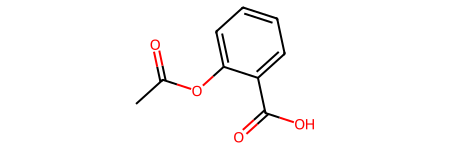

In [18]:
print(f"Name:\t{df.name[100]}\nSMILES:\t{df.smiles[100]}\nBBBP:\t{df.p_np[100]}")
molecule = molecule_from_smiles(df.iloc[100].smiles)
print("Molecule:")
molecule

In [19]:
graph = graph_from_molecule(molecule)
print("Graph (including self-loops):")
print("\tatom features\t", graph[0].shape)
print("\tbond features\t", graph[1].shape)
print("\tpair indices\t", graph[2].shape)


Graph (including self-loops):
	atom features	 (13, 29)
	bond features	 (39, 7)
	pair indices	 (39, 2)


### Create a `tf.data.Dataset`

In this tutorial, the MPNN implementation will take as input (per iteration) a single graph.
Therefore, given a batch of (sub)graphs (molecules), we need to merge them into a
single graph (we'll refer to this graph as *global graph*).
This global graph is a disconnected graph where each subgraph is
completely separated from the other subgraphs.

In [20]:

def prepare_batch(x_batch, y_batch):
    """Merges (sub)graphs of batch into a single global (disconnected) graph
    """

    atom_features, bond_features, pair_indices = x_batch

    # Obtain number of atoms and bonds for each graph (molecule)
    num_atoms = atom_features.row_lengths()
    num_bonds = bond_features.row_lengths()

    # Obtain partition indices (molecule_indicator), which will be used to
    # gather (sub)graphs from global graph in model later on
    molecule_indices = tf.range(len(num_atoms))
    molecule_indicator = tf.repeat(molecule_indices, num_atoms)

    # Merge (sub)graphs into a global (disconnected) graph. Adding 'increment' to
    # 'pair_indices' (and merging ragged tensors) actualizes the global graph
    gather_indices = tf.repeat(molecule_indices[:-1], num_bonds[1:])
    increment = tf.cumsum(num_atoms[:-1])
    increment = tf.pad(tf.gather(increment, gather_indices), [(num_bonds[0], 0)])
    pair_indices = pair_indices.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    pair_indices = pair_indices + increment[:, tf.newaxis]
    atom_features = atom_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()
    bond_features = bond_features.merge_dims(outer_axis=0, inner_axis=1).to_tensor()

    return (atom_features, bond_features, pair_indices, molecule_indicator), y_batch


def MPNNDataset(X, y, batch_size=32, shuffle=False):
    dataset = tf.data.Dataset.from_tensor_slices((X, (y)))
    if shuffle:
        dataset = dataset.shuffle(1024)
    return dataset.batch(batch_size).map(prepare_batch, -1).prefetch(-1)


## Model

The MPNN model can take on various shapes and forms. In this tutorial, we will implement an
MPNN based on the original paper
[Neural Message Passing for Quantum Chemistry](https://arxiv.org/abs/1704.01212) and
[DeepChem's MPNNModel](https://deepchem.readthedocs.io/en/latest/api_reference/models.html#mpnnmodel).
The MPNN of this tutorial consists of three stages: message passing, readout and
classification.


### Message passing

The message passing step itself consists of two parts:

1. The *edge network*, which passes messages from 1-hop neighbors `w_{i}` of `v`
to `v`, based on the edge features between them (`e_{vw_{i}}`),
resulting in an updated node (state) `v'`. `w_{i}` denotes the `i:th` neighbor of
`v`.

2. The *gated recurrent unit* (GRU), which takes as input the most recent node state
and updates it based on previous node states. In
other words, the most recent node state serves as the input to the GRU, while the previous
node states are incorporated within the memory state of the GRU. This allows information
to travel from one node state (e.g., `v`) to another (e.g., `v''`).

Importantly, step (1) and (2) are repeated for `k steps`, and where at each step `1...k`,
the radius (or number of hops) of aggregated information from `v` increases by 1.

In [21]:

class EdgeNetwork(layers.Layer):
    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.bond_dim = input_shape[1][-1]
        self.kernel = self.add_weight(
            shape=(self.bond_dim, self.atom_dim * self.atom_dim),
            initializer="glorot_uniform",
            name="kernel",
        )
        self.bias = self.add_weight(
            shape=(self.atom_dim * self.atom_dim), initializer="zeros", name="bias",
        )
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Apply linear transformation to bond features
        bond_features = tf.matmul(bond_features, self.kernel) + self.bias

        # Reshape for neighborhood aggregation later
        bond_features = tf.reshape(bond_features, (-1, self.atom_dim, self.atom_dim))

        # Obtain atom features of neighbors
        atom_features_neighbors = tf.gather(atom_features, pair_indices[:, 1])
        atom_features_neighbors = tf.expand_dims(atom_features_neighbors, axis=-1)

        # Apply neighborhood aggregation
        transformed_features = tf.matmul(bond_features, atom_features_neighbors)
        transformed_features = tf.squeeze(transformed_features, axis=-1)
        aggregated_features = tf.math.unsorted_segment_sum(
            transformed_features,
            pair_indices[:, 0],
            num_segments=tf.shape(atom_features)[0],
        )
        return aggregated_features


class MessagePassing(layers.Layer):
    def __init__(self, units, steps=4, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.steps = steps

    def build(self, input_shape):
        self.atom_dim = input_shape[0][-1]
        self.message_step = EdgeNetwork()
        self.pad_length = max(0, self.units - self.atom_dim)
        self.update_step = layers.GRUCell(self.atom_dim + self.pad_length)
        self.built = True

    def call(self, inputs):
        atom_features, bond_features, pair_indices = inputs

        # Pad atom features if number of desired units exceeds atom_features dim.
        # Alternatively, a dense layer could be used here.
        atom_features_updated = tf.pad(atom_features, [(0, 0), (0, self.pad_length)])

        # Perform a number of steps of message passing
        for i in range(self.steps):
            # Aggregate information from neighbors
            atom_features_aggregated = self.message_step(
                [atom_features_updated, bond_features, pair_indices]
            )

            # Update node state via a step of GRU
            atom_features_updated, _ = self.update_step(
                atom_features_aggregated, atom_features_updated
            )
        return atom_features_updated


### Readout

When the message passing procedure ends, the k-step-aggregated node states are to be partitioned
into subgraphs (corresponding to each molecule in the batch) and subsequently
reduced to graph-level embeddings. In the
[original paper](https://arxiv.org/abs/1704.01212), a
[set-to-set layer](https://arxiv.org/abs/1511.06391) was used for this purpose.
In this tutorial however, a transformer encoder + average pooling will be used. Specifically:

* the k-step-aggregated node states will be partitioned into the subgraphs
(corresponding to each molecule in the batch);
* each subgraph will then be padded to match the subgraph with the greatest number of nodes, followed
by a `tf.stack(...)`;
* the (stacked padded) tensor, encoding subgraphs (each subgraph containing a set of node states), are
masked to make sure the paddings don't interfere with training;
* finally, the tensor is passed to the transformer followed by average pooling.

In [22]:

class PartitionPadding(layers.Layer):
    def __init__(self, batch_size, **kwargs):
        super().__init__(**kwargs)
        self.batch_size = batch_size

    def call(self, inputs):

        atom_features, molecule_indicator = inputs

        # Obtain subgraphs
        atom_features_partitioned = tf.dynamic_partition(
            atom_features, molecule_indicator, self.batch_size
        )

        # Pad and stack subgraphs
        num_atoms = [tf.shape(f)[0] for f in atom_features_partitioned]
        max_num_atoms = tf.reduce_max(num_atoms)
        atom_features_stacked = tf.stack(
            [
                tf.pad(f, [(0, max_num_atoms - n), (0, 0)])
                for f, n in zip(atom_features_partitioned, num_atoms)
            ],
            axis=0,
        )

        # Remove empty subgraphs (usually for last batch in dataset)
        gather_indices = tf.where(tf.reduce_sum(atom_features_stacked, (1, 2)) != 0)
        gather_indices = tf.squeeze(gather_indices, axis=-1)
        return tf.gather(atom_features_stacked, gather_indices, axis=0)


class TransformerEncoderReadout(layers.Layer):
    def __init__(
        self, num_heads=8, embed_dim=64, dense_dim=512, batch_size=32, **kwargs
    ):
        super().__init__(**kwargs)

        self.partition_padding = PartitionPadding(batch_size)
        self.attention = layers.MultiHeadAttention(num_heads, embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.average_pooling = layers.GlobalAveragePooling1D()

    def call(self, inputs):
        x = self.partition_padding(inputs)
        padding_mask = tf.reduce_any(tf.not_equal(x, 0.0), axis=-1)
        padding_mask = padding_mask[:, tf.newaxis, tf.newaxis, :]
        attention_output = self.attention(x, x, attention_mask=padding_mask)
        proj_input = self.layernorm_1(x + attention_output)
        proj_output = self.layernorm_2(proj_input + self.dense_proj(proj_input))
        return self.average_pooling(proj_output)


### Message Passing Neural Network (MPNN)

It is now time to complete the MPNN model. In addition to the message passing
and readout, a two-layer classification network will be implemented to make
predictions of BBBP.

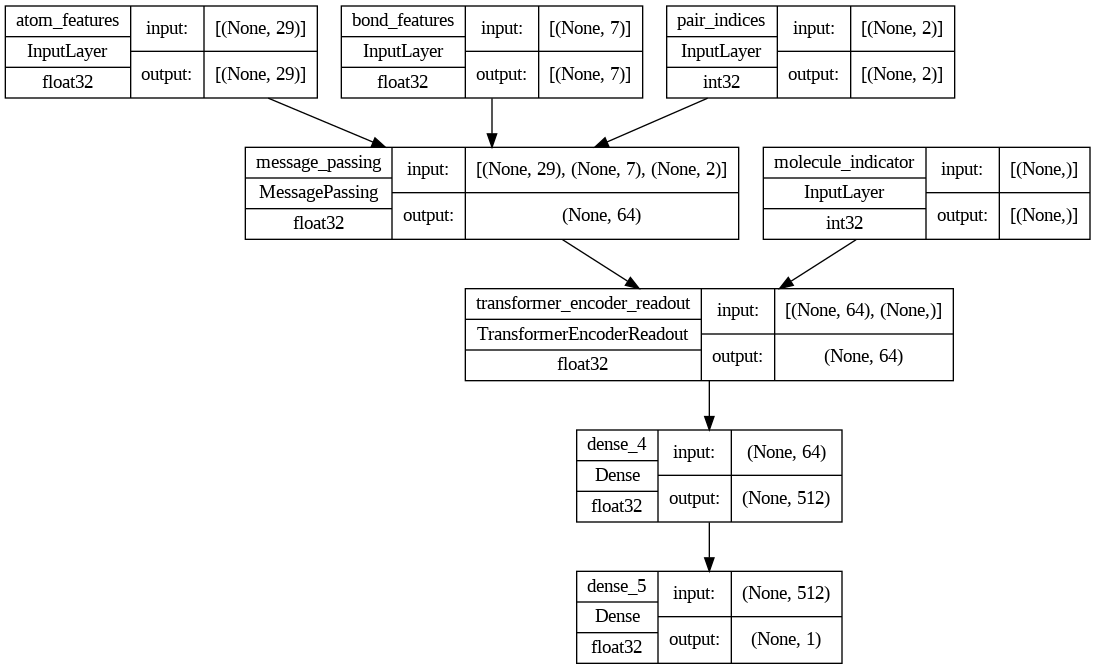

In [23]:

def MPNNModel(
    atom_dim,
    bond_dim,
    batch_size=32,
    message_units=64,
    message_steps=4,
    num_attention_heads=8,
    dense_units=512,
):

    atom_features = layers.Input((atom_dim), dtype="float32", name="atom_features")
    bond_features = layers.Input((bond_dim), dtype="float32", name="bond_features")
    pair_indices = layers.Input((2), dtype="int32", name="pair_indices")
    molecule_indicator = layers.Input((), dtype="int32", name="molecule_indicator")

    x = MessagePassing(message_units, message_steps)(
        [atom_features, bond_features, pair_indices]
    )

    x = TransformerEncoderReadout(
        num_attention_heads, message_units, dense_units, batch_size
    )([x, molecule_indicator])

    x = layers.Dense(dense_units, activation="relu")(x)
    x = layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(
        inputs=[atom_features, bond_features, pair_indices, molecule_indicator],
        outputs=[x],
    )
    return model


mpnn = MPNNModel(
    atom_dim=x_train[0][0][0].shape[0], bond_dim=x_train[1][0][0].shape[0],
)

mpnn.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=5e-4),
    metrics=[keras.metrics.AUC(name="AUC")],
)

keras.utils.plot_model(mpnn, show_dtype=True, show_shapes=True)

Epoch 1/40
52/52 - 12s - loss: 0.5262 - AUC: 0.7227 - val_loss: 0.6337 - val_AUC: 0.8301 - 12s/epoch - 239ms/step
Epoch 2/40
52/52 - 1s - loss: 0.4655 - AUC: 0.7926 - val_loss: 0.5881 - val_AUC: 0.8443 - 1s/epoch - 23ms/step
Epoch 3/40
52/52 - 1s - loss: 0.4519 - AUC: 0.8058 - val_loss: 0.5748 - val_AUC: 0.8514 - 1s/epoch - 24ms/step
Epoch 4/40
52/52 - 1s - loss: 0.4441 - AUC: 0.8153 - val_loss: 0.5664 - val_AUC: 0.8511 - 1s/epoch - 22ms/step
Epoch 5/40
52/52 - 1s - loss: 0.4336 - AUC: 0.8249 - val_loss: 0.5101 - val_AUC: 0.8550 - 1s/epoch - 22ms/step
Epoch 6/40
52/52 - 2s - loss: 0.4230 - AUC: 0.8356 - val_loss: 0.5292 - val_AUC: 0.8602 - 2s/epoch - 40ms/step
Epoch 7/40
52/52 - 2s - loss: 0.4168 - AUC: 0.8418 - val_loss: 0.4263 - val_AUC: 0.8616 - 2s/epoch - 38ms/step
Epoch 8/40
52/52 - 2s - loss: 0.4153 - AUC: 0.8463 - val_loss: 0.5266 - val_AUC: 0.8701 - 2s/epoch - 40ms/step
Epoch 9/40
52/52 - 3s - loss: 0.4078 - AUC: 0.8511 - val_loss: 0.5230 - val_AUC: 0.8770 - 3s/epoch - 58ms/ste

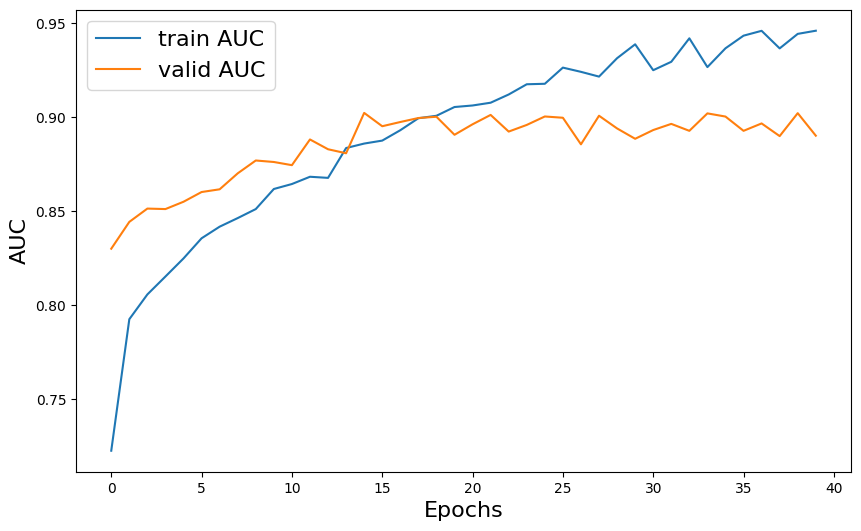

In [24]:
train_dataset = MPNNDataset(x_train, y_train)
valid_dataset = MPNNDataset(x_valid, y_valid)
test_dataset = MPNNDataset(x_test, y_test)

history = mpnn.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=40,
    verbose=2,
    class_weight={0: 2.0, 1: 0.5},
)

plt.figure(figsize=(10, 6))
plt.plot(history.history["AUC"], label="train AUC")
plt.plot(history.history["val_AUC"], label="valid AUC")
plt.xlabel("Epochs", fontsize=16)
plt.ylabel("AUC", fontsize=16)
plt.legend(fontsize=16)

1/1 [==============================] - 2s 2s/step


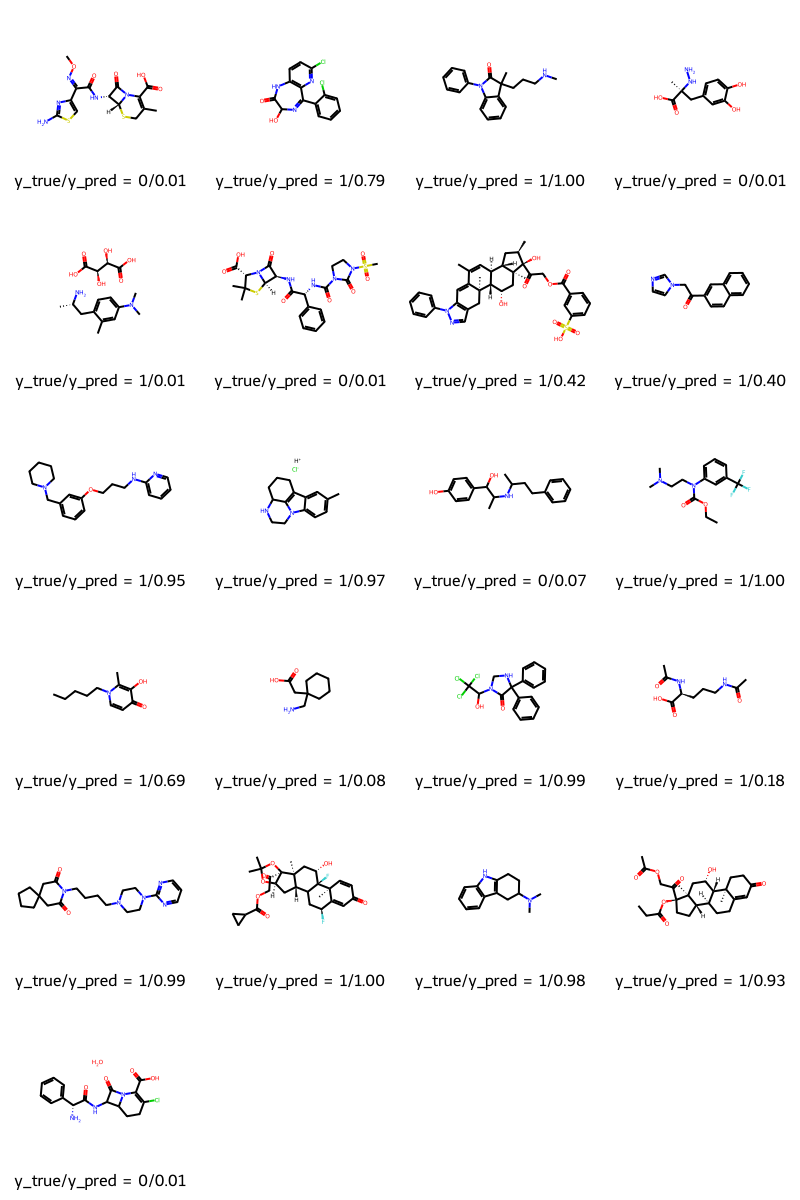

In [25]:
molecules = [molecule_from_smiles(df.smiles.values[index]) for index in test_index]
y_true = [df.p_np.values[index] for index in test_index]
y_pred = tf.squeeze(mpnn.predict(test_dataset), axis=1)

legends = [f"y_true/y_pred = {y_true[i]}/{y_pred[i]:.2f}" for i in range(len(y_true))]
MolsToGridImage(molecules, molsPerRow=4, legends=legends)

## Conclusions

In this tutorial, we demonstarted a message passing neural network (MPNN) to
predict blood-brain barrier permeability (BBBP) for a number of different molecules. We
first had to construct graphs from SMILES, then build a Keras model that could
operate on these graphs, and finally train the model to make the predictions.

Example available on HuggingFace

| Trained Model | Demo |
| :--: | :--: |
| [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Model-mpnn%20molecular%20graphs-black.svg)](https://huggingface.co/keras-io/MPNN-for-molecular-property-prediction) | [![Generic badge](https://img.shields.io/badge/%F0%9F%A4%97%20Spaces-mpnn%20molecular%20graphs-black.svg)](https://huggingface.co/spaces/keras-io/molecular-property-prediction) |

# **Graph Neural Networks with PyTorch Geometric**
[Gage DeZoort](https://github.com/gagedezoort), 3/27/23

Similar examples can be found at https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html

Several cells evolved from a notebook created by [Savannah Thais](https://github.com/savvy379).

**Introduction**
This notebook teaches the reader how to build and train Graph Neural Networks (GNNs) with Pytorch Geometric (PyG). The first portion walks through a simple GNN architecture applied to the Cora Dataset; it is a modified version of the PyG [Tutorial](https://pytorch-geometric.readthedocs.io/en/latest/notes/colabs.html) on node classifying GNNs. Before diving in, let's set up our software environment:

A graph $G$ is a mathematical object consisting of a set of nodes (vertices) $V$ and their pairwise relationships encoded as edges $E$, i.e. $G=(V,E)$. In the following we will usually denote $|V|=n_\mathrm{nodes}$ and $|E|=n_\mathrm{edges}$. Graphs can easily represent a wide range of structured data including atoms in molecules (nodes=atoms, edges=molecular bonds), users in a social network (nodes=people, edges=social connections), cities and roads in a transportation system (nodes=cities, edges=roads), planetary simulations (nodes=planets, edges=gravitational interactions), and more.

##  1.1 Karate Club
Let's take a look at an example graph in PyG. The Zachary Karate Club dataset (1977) is a social network describing friendships in a university karate club:
- 34 nodes (members of the karate club)
- 78 edges (friendships outside of the club)

A conflict arose between an instructor and an adminstrator, causing a faction in the club - half of the members formed a new karate club around the previous instructor and half either found a new instructor or quit karate.
- Truth labels: faction, 0 or 1 (per node)

Note that this is a single graph, and the goal is to perform *node classification* on the training set of nodes (a subset of all the nodes in the graph). In this way, Karate Club is used for semi-supervised node classification.

##  1.1 Karate Club
Let's take a look at an example graph in PyG. The Zachary Karate Club dataset (1977) is a social network describing friendships in a university karate club:
- 34 nodes (members of the karate club)
- 78 edges (friendships outside of the club)

A conflict arose between an instructor and an adminstrator, causing a faction in the club - half of the members formed a new karate club around the previous instructor and half either found a new instructor or quit karate.
- Truth labels: faction, 0 or 1 (per node)

Note that this is a single graph, and the goal is to perform *node classification* on the training set of nodes (a subset of all the nodes in the graph). In this way, Karate Club is used for semi-supervised node classification.

In [ ]:
from torch_geometric.datasets import KarateClub

# KarateClub is a small, easily visualized community graph
karate_club = KarateClub()._data

ModuleNotFoundError: No module named 'torch_geometric'

In [ ]:
# EXERCISE




As a brief aside, let's take a look at how PyG stores edges. In a fully connected graph, there are $\frac{1}{2}n_\mathrm{nodes}(n_\mathrm{nodes}-1)$ edges. Sparse graphs have relatively few edges, i.e. $n_\mathrm{edges}\ll \frac{1}{2}n_\mathrm{nodes}(n_\mathrm{nodes}-1)$. Adjacency matrices aren't necessarily the best way to represent sparse graphs - instead, packages like PyG use edge index lists in COO format.

In [ ]:
# edge lists (COO format)
out_nodes = karate_club.edge_index[0]
print('edges move out of the following nodes:\n', out_nodes)
in_nodes = karate_club.edge_index[1]
print('edges move into the following nodes:\n', in_nodes)

In [ ]:
# more details about the graph
def get_graph_stats(data):
  print(f'Number of nodes: {data.num_nodes}')
  print(f'Number of edges: {data.num_edges}')
  print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
  print(f'Number of training nodes: {data.train_mask.sum()}')
  print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
  print(f'Has isolated nodes: {data.has_isolated_nodes()}')
  print(f'Has self-loops: {data.has_self_loops()}')
  print(f'Is undirected: {data.is_undirected()}')

get_graph_stats(karate_club)

Okay, good, we've taken a look at our first instance of `Data`. Now let's visualize the graph; note that here it has 4 truth labels instead of 2, which have been generated by a graph clustering algorithm (if you're interested see [this ref](https://ieeexplore.ieee.org/document/4358966), but it's not important here). We'll use `networkx`, a networks dynamics software package, to visualize the graph.

In [ ]:
import torch_geometric
import networkx as networkx
print('Truth labels', karate_club.y)
karate_club_nx = torch_geometric.utils.to_networkx(karate_club, to_undirected=True)
plt.figure(figsize=(10,10))
nx.draw(karate_club_nx, with_labels=True, node_color=karate_club.y)

## 1.2 ENZYMES Graphs

Karate Club is used for semi-supervised node classification; let's look at a dataset used for graph-level classification. The [ENZYMES dataset](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.TUDataset.html#torch_geometric.datasets.TUDataset)
contains 600 graphs representing proteins with ~32.6 nodes (secondary structure elements - helices, turns or sheets) and ~124.3 edges (denoting neighbors in space or in the amino acid sequence) each. For expert details see the [TUDataset paper](https://arxiv.org/pdf/2007.08663.pdf). The goal is to assign each protein to one of 6 enzyme commission numbers, which describe the chemical reaction the enzyme catalyzes.

In [ ]:
from torch_geometric.datasets import TUDataset
dataset = TUDataset(root='/tmp/TUDataset', name="ENZYMES", use_node_attr=True)
dataset.data

**Exercise 1.1c**: Notice also that the data batches appear to have concatenate the nodes and edges of all the graphs into a single "batch graph." How does this work? (Hint: look at the `batch` attribute appended to each batch.)

In general, GNNs work by leveraging local information across the graph structure to intelligently compute new features for the nodes (and/or edges). A commonly used class of GNNs is the Graph Convolutional Network (GCN). GCNs use more-or-less the same convolution operations you've seen used in convolutional neural networks; however, instead of applying them to patches of images, they apply them to node neighborhoods. "Messages" are computed from each of a node's neighbors, and these messages are "passed" back to the node and used to update its features. We're going to make this painfully concrete; first, here's a schematic:

![](https://drive.google.com/uc?id=1f5MJO9Kw1tWjJMBJBsZ-M4tMFz_dydr2)

## 2.1 Graph Convolutional NNs

Let's look at a graph convolutional network (GCN) as originally posed in [Semi-Supervised Classification with Graph Convolutional Networks
](https://arxiv.org/pdf/1609.02907.pdf). Don't worry if the details aren't super clear, we'll highlight the most important things to remember.

Fix a graph with node features stacked into a matrix $\mathbf{X}^{(0)}\in\mathbb{R}^{n_\mathrm{nodes}\times d_V}$ and an adjacency matrix $\mathbf{A} \in [0,1]^{n_\mathrm{nodes}\times n_\mathrm{nodes}}$. A GCN will repeatedly apply graph convolutions to come up with new hidden representations of each node $\mathbf{X}^{(\ell)}$, where $\ell$ counts how many GCN layers you've applied. The forward pass of a GCN is based on message passing by taking a weighted average over each node's neighborhood. The weighted average is performed using a matrix $\mathbf{P}$ that is constructed from $\mathbf{A}$ - it is the symmetric degree-normalized adjacency matrix with self-loops - so that given a matrix $\mathbf{W}^{(\ell+1)}$ of trainable weights (no biases!) the GCN forward pass looks like this:

- GCN Forward Pass:
$$
\mathbf{X}^{(\ell+1)} = \mathbf{P}\sigma(\mathbf{X}^{(\ell)})\mathbf{W}^{(\ell+1)}
$$

Here, $\sigma$ is any non-linearity (activation function).
This forward pass should look pretty familiar! It's just like the forward pass of a feedforward NN applied to each node, where we're mixing up the node features by multiplying with $\mathbf{P}$ - this is neural message passing. Let's compare:

- DNN:
$$\mathbf{x}^{(\ell+1)} = \sigma(\mathbf{x}^{(\ell)})\mathbf{W}^{(\ell+1)}$$
- GCN:  
$$\mathbf{X}^{(\ell+1)} = \mathbf{P}\sigma(\mathbf{X}^{(\ell)})\mathbf{W}^{(\ell+1)}$$


We can re-cast the GCN matrix equation in terms of our familiar message-passing notation:

$$
\mathbf{x}_v^{(\ell + 1)} = \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \mathbf{x}_w^{(\ell)}\mathbf{W}^{(\ell + 1)}
$$

Here, $c_{w,v}$ refers to a fixed normalization coefficient for each edge; in the original formulation, $c(w,v)=\sqrt{\big((deg(w)+1)(deg(v)+1)\big)}$. This should make it clear that $\mathbf{P}$ simply computes a weighted sum of the neighborhood features for each node.

## 2.2 Cora (Karate Club but bigger!)

We will now use the [Cora dataset](https://relational.fit.cvut.cz/dataset/CORA) to predict the subject of a research paper given its words and citation network. The learning task is the same as it was with Karate Club, semi-supervised node classification. The Cora dataset consists of

- 2,708 nodes (scientific papers)
- 7 truth classes (paper subjects)
- 5,429 edges (representing citations)
- 1,433 node features (each a binary field indicating the presence of a word in the corresponding paper)

Let's go!

In [ ]:
# import the cora citation network
from torch_geometric.datasets import Planetoid
cora_dataset = Planetoid(root='data/Planetoid', name='Cora')

In [ ]:
# there is only one graph in this dataset
cora = cora_dataset[0]
cora

In [ ]:
# use our previous function to inspect Cora
get_graph_stats(cora)

In [ ]:
# let's visualize the graph
plt.figure(figsize=(10,10))
cora_nx = torch_geometric.utils.to_networkx(cora, to_undirected=True)
nx.draw(cora_nx, node_size=15, node_color=cora.y)

Okay, now it's time to set up a GCN using PyG! Reminder: we can construct a GNN in PyG similary to how we build a standard feed-forward neural network. We just need to swap the `torch.nn.Linear` layers with PyG's `GCNConv` implementing the graph convolution:

$$
\mathbf{x}_v^{(\ell + 1)} =  \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \mathbf{x}_w^{(\ell)}\mathbf{W}^{(\ell + 1)}
$$

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(cora_dataset.num_node_features, 16)
        self.conv2 = GCNConv(16, cora_dataset.num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index) # apply first GCN convolution
        x = F.relu(x) # hidden graph embedding
        x = F.dropout(x, training=self.training) # randomly drop training nodes
        x = self.conv2(x, edge_index) # output graph embedding

        return F.log_softmax(x, dim=1)

We're just trying to predict the right subject for each paper, hence the $\texttt{log_softmax}$ post-activation. This GCN is very similar to the [original implementation](https://github.com/tkipf/pygcn).

Let's take a look at the predictions of an untrained GCN by looking at a low dimensional representation:

In [ ]:
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

# examine the output of an untrained GCN
model = GCN()
model.eval()
out = model(cora)
visualize(out, color=cora.y)

In [ ]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

model = GCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.CrossEntropyLoss()

def train(data):
      model.train()
      optimizer.zero_grad()  # Clear gradients.
      out = model(data)  # Perform a single forward pass.
      loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      return loss

def test(data):
      model.eval()
      out = model(data)
      pred = out.argmax(dim=1)  # Use the class with highest probability.
      test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
      test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
      return test_acc

for epoch in range(1, 101):
    loss = train(cora)
    print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

In [ ]:
test_acc = test(cora)
print(f'Test Accuracy: {test_acc:.4f}')

Not perfect, but it's pretty accurate at predicting paper subject area!

We can further verify that  by looking at the output embeddings of our **trained** model, which now produces a far better clustering of nodes of the same category.



In [ ]:
model.eval()

out = model(cora)
visualize(out, color=cora.y)

**Exercise 2.2b** Play around with the training loop above! Some guiding questions:

- How does GCN behave when increasing the hidden feature dimensionality or the number of layers? Does increasing the number of layers help at all?

- So far, we've just looked at GCNConv operations. You can try to use different GNN layers to see how model performance changes. What happens if you swap out all GCNConv instances with GATConv layers that make use of attention? Try to write a 2-layer GAT model that makes use of 8 attention heads in the first layer and 1 attention head in the second layer, uses a dropout ratio of 0.6 inside and outside each GATConv call, and uses a hidden_channels dimensions of 8 per head.

In [ ]:
# let's re-load the dat
enzymes = TUDataset(root='/tmp/TUDataset', name="ENZYMES", use_node_attr=True)
train_loader = DataLoader(enzymes[:400], batch_size=32, shuffle=True)
test_loader = DataLoader(enzymes[400:], shuffle=False)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn.pool import global_mean_pool

class PoolingGCN(torch.nn.Module):
    def __init__(self):
        super().__init__()

        # EXERCISE: add the correct input and output dimensions:
        self.conv1 = GCNConv(, 512, cached=False)
        self.conv2 = GCNConv(512, , cached=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index) # apply first GCN convolution
        x = F.relu(x) # hidden graph embedding
        #x = F.dropout(x, training=self.training) # randomly drop training nodes
        x = self.conv2(x, edge_index) # output graph embedding

        # EXERCISE: global mean pool x

        return F.log_softmax(x, dim=1)

In [ ]:
model = PoolingGCN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

def train_step(train_loader):
    model.train()
    for batch in train_loader:
        optimizer.zero_grad()  # Clear gradients.
        out = model(batch)  # Perform a single forward pass.
        loss = criterion(out, batch.y)  # Compute the loss solely based on the training nodes.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
    return loss

def test_step(test_loader):
    model.eval()
    # EXERCISE: write a test step and evaluate your model

for epoch in range(1, 101):
    train_loss = train_step(train_loader)
    if not epoch%10:
        print(f'Epoch: {epoch:03d}, Loss: {train_loss:.4f}')

# 4. Message Passing Under the Hood (Optional)
You may be wondering how the PyG implementation of the GCN compares to our $\mathbf{P}$ matrix aggregations above. Well, according to the [docs](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv),

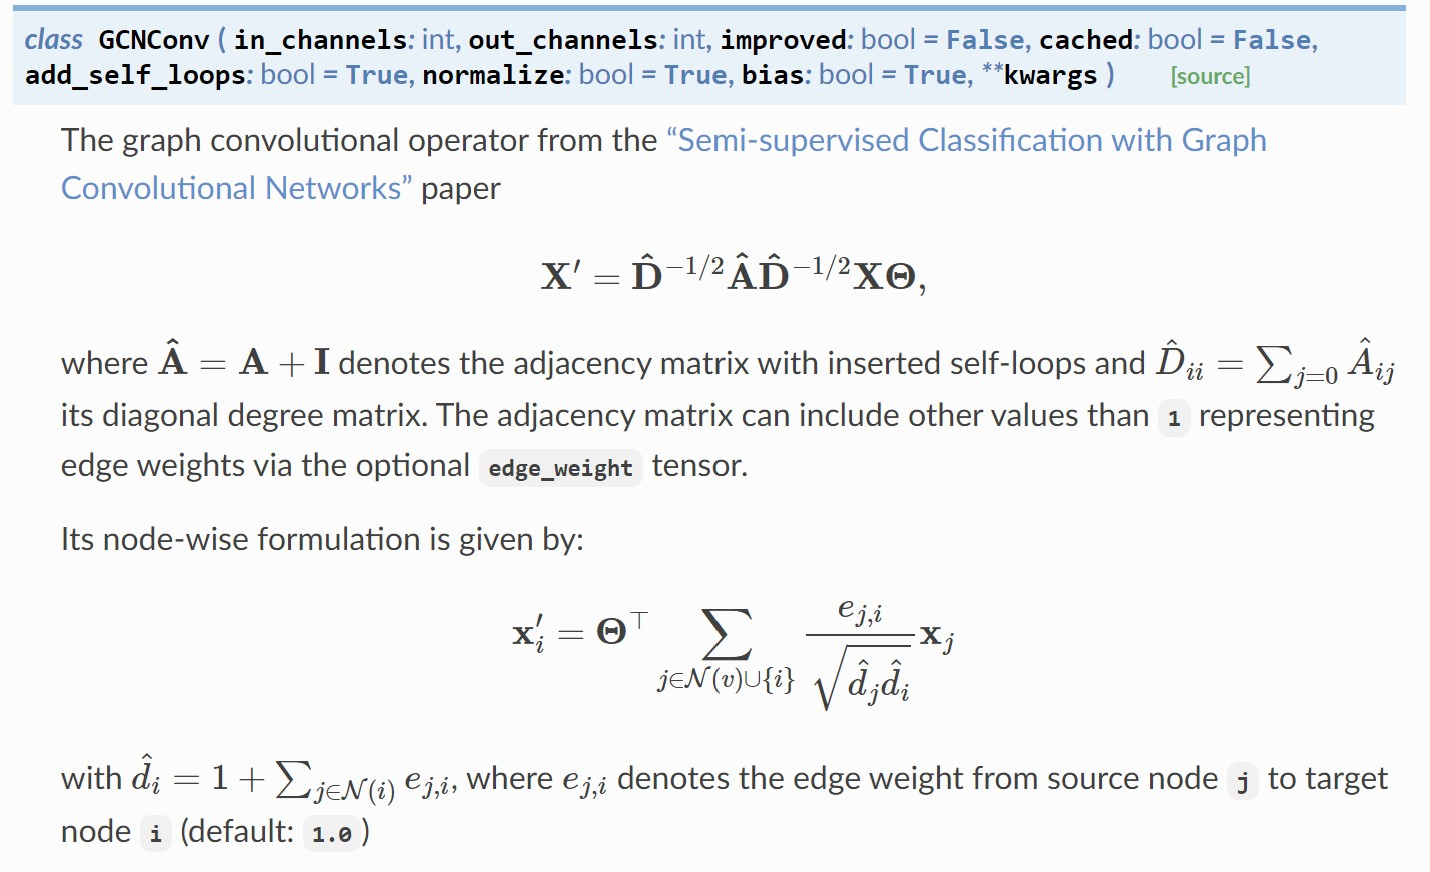

In [ ]:
from typing import Optional, Tuple

import torch
from torch import Tensor
from torch_scatter import scatter_add

from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.dense.linear import Linear
from torch_geometric.nn.inits import zeros
from torch_geometric.typing import Adj, PairTensor
from torch_geometric.utils import add_remaining_self_loops
from torch_geometric.utils.num_nodes import maybe_num_nodes

def gcn_norm(edge_index, num_nodes=None,
             add_self_loops=True, dtype=None):

    num_nodes = maybe_num_nodes(edge_index, num_nodes)
    edge_weight = torch.ones((edge_index.size(1), ), dtype=dtype,
                              device=edge_index.device)
    edge_index, edge_weight = add_remaining_self_loops(
        edge_index, edge_weight, 1, num_nodes)

    #
    row, col = edge_index[0], edge_index[1]
    deg = scatter_add(edge_weight, col, dim=0, dim_size=num_nodes)
    deg_inv_sqrt = deg.pow_(-0.5)
    deg_inv_sqrt.masked_fill_(deg_inv_sqrt == float('inf'), 0)
    return edge_index, deg_inv_sqrt[row] * edge_weight * deg_inv_sqrt[col]

class SimpleGCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels,
                 add_self_loops = True,  **kwargs):

        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.add_self_loops = add_self_loops
        self.lin = Linear(in_channels, out_channels, bias=False,
                          weight_initializer='glorot')
        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()

    def forward(self, x, edge_index,):
        edge_index, edge_weight = gcn_norm(
            edge_index, x.size(self.node_dim),
            self.add_self_loops
        )
        x = self.lin(x)
        out = self.propagate(
            edge_index, x=x, edge_weight=edge_weight, size=None
        )
        return out

    def message(self, x_j, edge_weight):
        return edge_weight.view(-1, 1) * x_j

In [ ]:
# check a few examples
def check_edge(idx):
  print(f'\nChecking edge #{idx}')
  out_node, in_node = edge_index[:,idx]
  print(f'...edge extends from {out_node} to {in_node}')
  print(f'...corresponding entry in P: {P[out_node, in_node]}')
  print(f'...corresponding entry in edge_weights: {edge_weight[idx]}')

check_edge(29)
check_edge(3)
check_edge(0)

Evidently, PyG computes the exact same matrix $\textbf{P}$ and maps it onto an edge weight vector `edge_weight`$\in\mathbb[0,1]^{2\times|E|}$. Instead of multiplying matrices, PyG keeps track of edge lists and uses element-wise indexing/multiplication.

So, we get the right normalization. That's great! Now how do we compute a message passing iteration without matrix multiplication by $\mathbf{P}$?

Let's look at the forward pass:

```
def forward(self, x, edge_index,):
    edge_index, edge_weight = gcn_norm(  
        edge_index, x.size(self.node_dim),
        self.add_self_loops
    )
    x = self.lin(x)
    out = self.propagate(
        edge_index, x=x, edge_weight=edge_weight, size=None
    )
    return out  
```

In the first lines we call the `normalize` function to build the $\mathbf{P}$ matrix in the form of `edge_weights`. That checks out!

$$ \texttt{edge_weights}\ \leftrightarrow\ \mathbf{P}$$

Next, we apply a learnable linear transform to our input feature, which is $\sigma(X^{(\ell)})$ from the previous hidden layer.

$$ \texttt{x = self.lin(x)}\ \leftrightarrow\ \mathbf{X}^{(\ell+1)}=\sigma(\mathbf{X}^{(\ell)})\mathbf{W}^{(\ell+1)}$$

We then call `self.propagate`, which initiates message passing under the hood. This is a PyG convention; whenever `propagate` is called, pairs of nodes ($\mathbf{x}_i, \mathbf{x}_j$) connected by an edge in `edge_index` are formed and passed through the user-defined `message` function. Here, we've defined:

```
def message(self, x_j, edge_weight):
        return edge_weight.view(-1, 1) * x_j
```

As we saw above, each message from node $j$ to node $i$ is just $\frac{1}{c_{j,i}} \cdot \mathbf{x}_j^{(\ell)}$, where $c_{j,i}=\sqrt{\text{deg}(j)+1}\sqrt{\text{deg}(i)+1}$ is the normalization constant in $\mathbf{P}$ (`edge_weight`).

Finally, PyG calls `aggregate` based on the user's choice of aggregation function. Since the GCN aggregation strategy is matrix multiplication, we're using `add` aggregation. We set this as a default kwarg in the `SimpleGCNConv` class. The PyG message passing `update` function updates the state of each node based on these aggregated messages (in general by applying another NN to them, but here we simply take the sum).

$$ \texttt{message}, \texttt{aggregate} \leftrightarrow\ \mathbf{P}\sigma(\mathbf{X}^{(\ell)})\mathbf{W}^{(\ell+1)}$$
$$ \texttt{update}\ \leftrightarrow\ \mathbf{X}^{(\ell+1)} = \mathbf{P}\sigma(\mathbf{X}^{(\ell)})\mathbf{W}^{(\ell+1)}$$


Schematically, based on https://pytorch-geometric.readthedocs.io/en/latest/notes/sparse_tensor.html

```
from torch_scatter import scatter

x = ...           # Node features of shape [num_nodes, num_features]
edge_index = ...  # Edge indices of shape [2, num_edges]
edge_weight = ... # Edge weights of shape [1, num_edges]

x_j = x[edge_index[0]]  # Source node features [num_edges, num_features]
x_i = x[edge_index[1]]  # Target node features [num_edges, num_features]

msg = edge_weight.view(-1,1) * x_j  # Compute message for each edge

# Aggregate messages based on target node indices
out = scatter(msg, edge_index[1], dim=0, dim_size=x.size(0), reduce="add")
```


# answers to exercises:

# Exercise 1.1a
# print(karate_club.x)
# print(karate_club.edge_index)
# print(karate_club.y)

# Exercise 1.1b
# A = torch_geometric.utils.to_dense_adj(karate_club.edge_index).squeeze()
#print('adjacency representation', A)

# Exercise 1.1c
# Batching in PyG works by concatenating nodes and creating a block diagonal adacency matrix.
# Membership is tracked through the `batch` attribute appended to each graph batch.
# See: https://pytorch-geometric.readthedocs.io/en/latest/advanced/batching.html

# Exercise 2.2a
# sum(cora.train_mask)
# There are 140 training nodes, 20 from each of the 7 truth classes.
# This means overtraining is a real possibility and regularization will be important.

# Exercise 2.2b
# Adding more layers doesn't help too much (and even hurts if the network becomes too deep)!
# This is because node features get "washed out" across the graph.

# Exercise 3a
# 21 input features, 6 output classes
# x = global_mean_pool(x, data.batch)

# Exercise 3b
# Just copy the train loop structure and the accuracy metric from the Cora train loop.
# But remember accuracy is computed per-graph now!

https://colab.research.google.com/github/GageDeZoort/prc_gnn_tutorial/blob/main/gnn_tutorial.ipynb#scrollTo=quOauueqYuIZ